In [1]:
# Load libraries

# # Plotting utils 
import datetime
import glob
import os
import pickle
import time
import warnings
from datetime import date, timedelta
import Ngl
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.util
import matplotlib as matplotlib
import matplotlib.animation as animation
import matplotlib.colors as colors
import matplotlib.dates as mdates
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.ticker import FormatStrFormatter
import metpy.calc as mpc
import numpy as np
import pandas as pd
import scipy.stats as stats
import seaborn as sns
import xarray as xr
from matplotlib.dates import DateFormatter
from metpy.units import units
from metpy import interpolate
from metpy.calc import vertical_velocity
from mpl_toolkits.axes_grid1 import make_axes_locatable

warnings.filterwarnings('ignore')


## Define useful functions

In [3]:
# Grabbed from Brian M. to use time midpoints, not end periods
def cesm_correct_time(ds):
    """Given a Dataset, check for time_bnds,
       and use avg(time_bnds) to replace the time coordinate.
       Purpose is to center the timestamp on the averaging inverval.   
       NOTE: ds should have been loaded using `decode_times=False`
    """
    assert 'time_bnds' in ds
    assert 'time' in ds
    correct_time_values = ds['time_bnds'].mean(dim='nbnd')
    # copy any metadata:
    correct_time_values.attrs = ds['time'].attrs
    ds = ds.assign_coords({"time": correct_time_values})
    ds = xr.decode_cf(ds)  # decode to datetime objects
    return ds

In [4]:
# - - - - - - - - - - - - - - - 
# Pressure interpolation 
# - - - - - - - - - - - - - - - 

def interpolateToPressure_v2(DS, varName, pressGoals):
    p0mb = DS.P0.values/100        # mb

    # Pull out hya/hyb profiles 
    hyam = np.squeeze(DS.hyam.values)[:]
    hybm = np.squeeze(DS.hybm.values)[:]
    hyai = np.squeeze(DS.hyai.values)[:]
    hybi = np.squeeze(DS.hybi.values)[:]

    # Surface pressure with time dimension
    PS   = DS.PS.values              # Pa 

    # Converting variables: 
    if np.shape(DS[varName].values)[1]==len(DS.ilev.values):
        varInterp = Ngl.vinth2p(DS[varName].values,hyai,hybi,pressGoals,PS,1,p0mb,1,True)
    elif np.shape(DS[varName].values)[1]==len(DS.lev.values):
        varInterp = Ngl.vinth2p(DS[varName].values,hyam,hybm,pressGoals,PS,1,p0mb,1,True)
    ## Handle data that's by-plume for EDMF output
    elif np.shape(DS[varName].values)[1]==len(DS.nens.values):
        varInterp = np.full([len(DS.time.values), len(DS.nens.values) ,
                             len(pressGoals), len(DS.lat.values), len(DS.lon.values)], np.nan)
        
        for iEns in range(len(DS.nens.values)):
            varInterp[:,iEns,:,:,:] = Ngl.vinth2p(DS[varName].values[:,iEns,:,:,:],hyai,hybi,pressGoals,PS,1,p0mb,1,True)

    saveOut = varInterp
    
    return saveOut

def interpolateToPressure_v2_h2(DS, DSctrl, varName, pressGoals):
    p0mb = DSctrl.P0.values/100        # mb

    # Pull out hya/hyb profiles 
    hyam = np.squeeze(DSctrl.hyam.values)[:]
    hybm = np.squeeze(DSctrl.hybm.values)[:]
    hyai = np.squeeze(DSctrl.hyai.values)[:]
    hybi = np.squeeze(DSctrl.hybi.values)[:]

    # Surface pressure with time dimension
    PS   = DSctrl.PS.values              # Pa 

    # Converting variables: 
    if np.shape(DS[varName].values)[1]==len(DS.ilev.values):
        varInterp = Ngl.vinth2p(DS[varName].values,hyai,hybi,pressGoals,PS,1,p0mb,1,True)
    elif np.shape(DS[varName].values)[1]==len(DS.lev.values):
        varInterp = Ngl.vinth2p(DS[varName].values,hyam,hybm,pressGoals,PS,1,p0mb,1,True)
    ## Handle data that's by-plume for EDMF output
    elif np.shape(DS[varName].values)[1]==len(DS.nens.values):
        varInterp = np.full([len(DS.time.values), len(DS.nens.values) ,
                             len(pressGoals), len(DS.lat.values), len(DS.lon.values)], np.nan)
        
        for iEns in range(len(DS.nens.values)):
            varInterp[:,iEns,:,:,:] = Ngl.vinth2p(DS[varName].values[:,iEns,:,:,:],hyai,hybi,pressGoals,PS,1,p0mb,1,True)

    saveOut = varInterp
    
    return saveOut


def interpolateToPressure_v2_h3(DS, DSctrl, varName, pressGoals):
    p0mb = DSctrl.P0.values/100        # mb

    # Pull out hya/hyb profiles 
    hyam = np.squeeze(DSctrl.hyam.values)[:]
    hybm = np.squeeze(DSctrl.hybm.values)[:]
    hyai = np.squeeze(DSctrl.hyai.values)[:]
    hybi = np.squeeze(DSctrl.hybi.values)[:]

    # Surface pressure with time dimension
    PS   = DSctrl.PS.values              # Pa 

    # Converting variables: 
    if np.shape(DS[varName].values)[1]==len(DS.ilev.values):
        varInterp = Ngl.vinth2p(DS[varName].values,hyai,hybi,pressGoals,PS,1,p0mb,1,True)
    elif np.shape(DS[varName].values)[1]==len(DS.lev.values):
        varInterp = Ngl.vinth2p(DS[varName].values,hyam,hybm,pressGoals,PS,1,p0mb,1,True)
    ## Handle data that's by-plume for EDMF output
    elif np.shape(DS[varName].values)[1]==len(DS.nens.values):
        varInterp = np.full([len(DS.time.values), len(DS.nens.values) ,
                             len(pressGoals), len(DS.lat.values), len(DS.lon.values)], np.nan)
        
        for iEns in range(len(DS.nens.values)):
            varInterp[:,iEns,:,:,:] = Ngl.vinth2p(DS[varName].values[:,iEns,:,:,:],hyai,hybi,pressGoals,PS,1,p0mb,1,True)
 
    ## Handle data that's by-plume *and* by subcycle for EDMF output
    elif np.shape(DS[varName].values)[2]==len(DS.nens.values):
        varInterp = np.full([len(DS.time.values), len(DS.ncyc.values), len(DS.nens.values) ,
                             len(pressGoals), len(DS.lat.values), len(DS.lon.values)], np.nan)
        
        for iEns in range(len(DS.nens.values)):
            for iCyc in range(len(DS.ncyc.values)):
                varInterp[:,iCyc,iEns,:,:,:] = Ngl.vinth2p(DS[varName].values[:,iCyc,iEns,:,:,:],hyai,hybi,pressGoals,PS,1,p0mb,1,True)

            
    saveOut = varInterp
    
    return saveOut

In [5]:
# - - - - - - - - - - - - - - - 
# Pre-process data while reading in 
# - - - - - - - - - - - - - - - 

def preprocess_h0(ds):
       
    keepVars = ['SWCF','LWCF','TS','CLOUD','FSNS','FLNS','PS','QREFHT',
                'U10','CLDHGH','CLDLIQ','CONCLD','TMQ','P0','hyam','hybm','hyai','hybi',
                'PHIS','USTAR','QT','GCLDLWP',
                'THETAL','CDNUMC','CLDBOT','CLDLOW',
                'CLDMED','CLDTOP','CLDTOT','THLP2_CLUBB','CLOUDCOVER_CLUBB','CLOUDFRAC_CLUBB',
                'RCM_CLUBB','RTP2_CLUBB','RTPTHLP_CLUBB','RVMTEND_CLUBB','STEND_CLUBB','UP2_CLUBB','UPWP_CLUBB',
                'VP2_CLUBB','T','Q','OMEGA','PBLH','U','V','WP2_CLUBB','WP3_CLUBB','WPRCP_CLUBB',
                'WPRTP_CLUBB',
                'WPTHLP_CLUBB','WPTHVP_CLUBB','Z3','PRECT','PRECC',
                'TGCLDCWP','TGCLDLWP','GCLDLWP',
                'LHFLX','SHFLX','TREFHT','RHREFHT']
        
    ds         = cesm_correct_time(ds)
    ds['time'] = ds.indexes['time'].to_datetimeindex() 
        
    ## Select the second simulated day for analysis 
    iTimeStart_day2  = np.where( (ds.time.values >= (ds.time.values[0] + np.timedelta64(1,'D'))) & 
                                 (ds.time.values < (ds.time.values[0] + np.timedelta64(2,'D'))))[0]
    dsSel      = ds.isel(time=np.sort(iTimeStart_day2))[keepVars]
    
    # Compute local time 
    localTimes = dsSel['time'].values - np.timedelta64(5,'h')
    dsSel      = dsSel.assign_coords({"time": localTimes})
    dsSel = dsSel.load()   

    return dsSel

def preprocess_h1(ds):
    
    keepVars = [
                'wpthlp','wprtp','rtp2',
                'thlm','rtm','wm_zm','rtm_zm','thlm_zm',
                ]
        
    ds         = cesm_correct_time(ds)
    ds['time'] = ds.indexes['time'].to_datetimeindex() 
        
    ## Select the second simulated day for analysis 
    iTimeStart_day2  = np.where( (ds.time.values >= (ds.time.values[0] + np.timedelta64(1,'D'))) & 
                                 (ds.time.values < (ds.time.values[0] + np.timedelta64(2,'D'))))[0]
    dsSel      = ds.isel(time=np.sort(iTimeStart_day2))[keepVars]

    
    # Compute local time 
    localTimes = dsSel['time'].values - np.timedelta64(5,'h')
    dsSel      = dsSel.assign_coords({"time": localTimes})
    dsSel = dsSel.load()
        
    return dsSel


def preprocess_h2(ds):
    
    varSels = np.asarray([
                      'edmf_upa','edmf_upw','edmf_upqt','edmf_upthl','edmf_cloudfrac','edmf_dnw',
                      'edmf_precc','edmf_uplh',
                      'edmf_ent','edmf_upent','edmf_updet','edmf_upbuoy',

                       ])

    ds         = cesm_correct_time(ds)
    ds['time'] = ds.indexes['time'].to_datetimeindex() 
        
    ## Select the second simulated day for analysis 
    iTimeStart_day2  = np.where( (ds.time.values >= (ds.time.values[0] + np.timedelta64(1,'D'))) & 
                                 (ds.time.values <= (ds.time.values[0] + np.timedelta64(2,'D'))))[0]
    dsSel      = ds[varSels].isel(time=np.sort(iTimeStart_day2))
    
    # Compute local time 
    localTimes = dsSel['time'].values - np.timedelta64(5,'h')
    dsSel      = dsSel.assign_coords({"time": localTimes})

    ## Replacing 'missing' updraft values with NaN 
    dsSel = dsSel.where(dsSel['edmf_upthl'] != 0.0)
    dsSel = dsSel.load()

    return dsSel


def preprocess_h2_2d(ds):
    
    varSels = np.asarray([
                      'edmf_cloudfrac','edmf_qtflxup','edmf_thlflxup','edmf_precc',
                      'edmf_S_ATHLTHL','edmf_S_AQTQT','edmf_S_AWW',
                      'edmf_L0',
                       ])

    ds         = cesm_correct_time(ds)
    ds['time'] = ds.indexes['time'].to_datetimeindex() 
        
    ## Select the second simulated day for analysis 
    iTimeStart_day2  = np.where( (ds.time.values >= (ds.time.values[0] + np.timedelta64(1,'D'))) & 
                                 (ds.time.values < (ds.time.values[0] + np.timedelta64(2,'D'))))[0]
    dsSel      = ds[varSels].isel(time=np.sort(iTimeStart_day2))
    
    # Compute local time 
    localTimes = dsSel['time'].values - np.timedelta64(5,'h')
    dsSel      = dsSel.assign_coords({"time": localTimes})
    dsSel = dsSel.load()
    
    return dsSel

def preprocess_h3(ds):

    ds         = cesm_correct_time(ds)
    ds['time'] = ds.indexes['time'].to_datetimeindex() 
        
    ## Select the second simulated day for analysis 
    iTimeStart_day2  = np.where( (ds.time.values >= (ds.time.values[0] + np.timedelta64(1,'D'))) & 
                                 (ds.time.values < (ds.time.values[0] + np.timedelta64(2,'D'))))[0]
    dsSel      = ds.isel(time=np.sort(iTimeStart_day2))
    
    # Compute local time 
    localTimes = dsSel['time'].values - np.timedelta64(5,'h')
    dsSel      = dsSel.assign_coords({"time": localTimes})
    
    ## Replacing 'missing' updraft values with NaN 
    dsSel   = dsSel.where(dsSel['thlu_macmic2'] != 0.0)
    dsSel = dsSel.load()
    
    return dsSel

def preprocessCLM_h0(ds):
    keepVars_CLM = ['SOILWATER_10CM','TSOI_10CM','RAIN','FSA','TG','TSA',
                    'QVEGT','QVEGE','QSOIL','H2OSOI','TSOI','SOILLIQ']

    ds['time'] = ds.indexes['time'].to_datetimeindex() 
        
    ## Select the second simulated day for analysis 
    iTimeStart_day2  = np.where( (ds.time.values >= (ds.time.values[0] + np.timedelta64(1,'D'))) & 
                                 (ds.time.values < (ds.time.values[0] + np.timedelta64(2,'D'))))[0]
    dsSel      = ds.isel(time=np.sort(iTimeStart_day2))[keepVars_CLM]
    
    # Compute local time 
    localTimes = dsSel['time'].values - np.timedelta64(5,'h')
    dsSel      = dsSel.assign_coords({"time": localTimes})
    dsSel = dsSel.load()

    return dsSel

def preprocessCLM_h1(ds):
    
    ds['time'] = ds.indexes['time'].to_datetimeindex() 
        
    ## Select the second simulated day for analysis 
    iTimeStart_day2  = np.where( (ds.time.values >= (ds.time.values[0] + np.timedelta64(1,'D'))) & 
                                 (ds.time.values < (ds.time.values[0] + np.timedelta64(2,'D'))))[0]
    dsSel      = ds.isel(time=np.sort(iTimeStart_day2))
    
    # Compute local time 
    localTimes = dsSel['time'].values - np.timedelta64(5,'h')
    dsSel      = dsSel.assign_coords({"time": localTimes})
        
    QFLX = dsSel.QSOIL+dsSel.QVEGE+dsSel.QVEGT
    dsSel['QFLX'] = (('time','pft'), QFLX)
    
    dsSel = dsSel.load()

    return dsSel

def preprocessCLM_h2(ds):
    
    ds['time'] = ds.indexes['time'].to_datetimeindex() 
        
    ## Select the second simulated day for analysis 
    iTimeStart_day2  = np.where( (ds.time.values >= (ds.time.values[0] + np.timedelta64(1,'D'))) & 
                                 (ds.time.values < (ds.time.values[0] + np.timedelta64(2,'D'))))[0]
    dsSel      = ds.isel(time=np.sort(iTimeStart_day2))
    
    # Compute local time 
    localTimes = dsSel['time'].values - np.timedelta64(5,'h')
    dsSel      = dsSel.assign_coords({"time": localTimes})
        
    QFLX = dsSel.QSOIL+dsSel.QVEGE+dsSel.QVEGT
    dsSel['QFLX'] = (('time','landunit'), QFLX)
    
    dsSel = dsSel.load()

    return dsSel

In [6]:
# - - - - - - - - - - - - - - - 
# Additional processing after files are read in 
# - - - - - - - - - - - - - - - 

def process_camData(DS):
    
    ## Interpolate to standard levels 
    # - - - - - - - - - - - - - - - - - - - - - - - -
    print('Beginning interpolation...') 
    
    # Decide on levels to interpoalte to and add to larger arrays
    pnew64 = np.arange(200.0,980.0,10.0) 
    
    DS = DS.assign_coords({"levInterp": pnew64})

    varSels = np.asarray(['THLP2_CLUBB','RTP2_CLUBB','RTPTHLP_CLUBB','WPRTP_CLUBB','WPTHLP_CLUBB','WP3_CLUBB','WP2_CLUBB','UP2_CLUBB',
                          'VP2_CLUBB','Z3','U','V','T','Q','OMEGA','RVMTEND_CLUBB','STEND_CLUBB','CLDLIQ','CLOUD','CLOUDFRAC_CLUBB',
                          'UPWP_CLUBB','THETAL',
                          'CONCLD','QT','GCLDLWP',
                          'wpthlp','wprtp','rtp2',
                          'thlm','rtm','wm_zm','rtm_zm','thlm_zm',
                          ])

    for iVar in range(len(varSels)): 
        # Interpolate variables and add to larger arrays 
        interpVar_real = interpolateToPressure_v2(DS, varSels[iVar], pnew64)

        if len(np.shape(interpVar_real))==4: 
            DS[varSels[iVar]+'_interp']  = (('time','levInterp','lat','lon'), interpVar_real)
        elif len(np.shape(interpVar_real))==5: 
            DS[varSels[iVar]+'_interp']  = (('time','nens','levInterp','lat','lon'), interpVar_real)

    ## Compute vertical velocity as m/s rather than Pa/s 
    w_mps = vertical_velocity( np.squeeze(DS['OMEGA_interp'].values)*units('Pa/s'), 
                               np.squeeze(DS['levInterp'].values)*units.hPa, 
                               np.squeeze(DS['T_interp'].values)*units.K )
    w_mps_save = np.full([len(DS.time.values), 
                      len(DS.levInterp.values), 
                      len(DS.lat.values), 
                      len(DS.lon.values)], np.nan)
    w_mps_save[:,:,0,0] = w_mps
    
    DS['w_mps'] = ( ('time','levInterp','lat,','lon'), w_mps_save)
        
    return DS


def process_camData_h2(DS, DSctrl):
    ## Interpolate to standard levels 
    # - - - - - - - - - - - - - - - - - - - - - - - -
    print('Beginning interpolation...') 
    
    # Decide on levels to interpoalte to and add to larger arrays
    pnew64 = np.arange(200.0,980.0,10.0) 
    
    DS = DS.assign_coords({"levInterp": pnew64})
    varSels = np.asarray([
                          'edmf_upa','edmf_upw','edmf_upqt','edmf_upthl',
                          'edmf_cloudfrac','edmf_dnw','edmf_precc',
                          'edmf_qtflxup','edmf_thlflxup',
                          'edmf_S_ATHLTHL','edmf_S_AQTQT','edmf_S_AWW',
                           'edmf_ent','edmf_upent','edmf_updet','edmf_upbuoy',

                           ])

    for iVar in range(len(varSels)): 
        # Interpolate variables and add to larger arrays 
        interpVar_real = interpolateToPressure_v2_h2(DS, DSctrl, varSels[iVar], pnew64)

        if len(np.shape(interpVar_real))==4: 
            DS[varSels[iVar]+'_interp']  = (('time','levInterp','lat','lon'), interpVar_real)
        elif len(np.shape(interpVar_real))==5: 
            DS[varSels[iVar]+'_interp']  = (('time','nens','levInterp','lat','lon'), interpVar_real)

    return DS

def process_camData_h3(DS, DSctrl):
    
    ## Interpolate to standard levels 
    # - - - - - - - - - - - - - - - - - - - - - - - -
    print('Beginning interpolation...') 
    
    # Decide on levels to interpoalte to and add to larger arrays
    pnew64 = np.arange(200.0,980.0,10.0) 
    
    DS = DS.assign_coords({"levInterp": pnew64})
    varSels = np.asarray([
                          'up_macmic1','up_macmic2','dn_macmic1','dn_macmic2',
                        'upa_macmic1','upa_macmic2','dna_macmic1','dna_macmic2',
                        'thlu_macmic1','thlu_macmic2','qtu_macmic1','qtu_macmic2',
                        'thld_macmic1','thld_macmic2','qtd_macmic1','qtd_macmic2',
                           ])
    
    for iVar in range(len(varSels)): 
        # Interpolate variables and add to larger arrays 
        interpVar_real = interpolateToPressure_v2_h3(DS, DSctrl, varSels[iVar], pnew64)

        if len(np.shape(interpVar_real))==4: 
            DS[varSels[iVar]+'_interp']  = (('time','levInterp','lat','lon'), interpVar_real)
        elif len(np.shape(interpVar_real))==5: 
            DS[varSels[iVar]+'_interp']  = (('time','nens','levInterp','lat','lon'), interpVar_real)
        elif len(np.shape(interpVar_real))==6: 
            DS[varSels[iVar]+'_interp']  = (('time','ncyc','nens','levInterp','lat','lon'), interpVar_real)
        
    return DS


In [7]:
def combineMacmic(ds_h3, ds_h2):
    var1    = ['up_macmic1_interp', 'dn_macmic1_interp','upa_macmic1_interp','dna_macmic1_interp',
           'thlu_macmic1_interp','qtu_macmic1_interp','thld_macmic1_interp','qtd_macmic1_interp']

    var2    = ['up_macmic2_interp', 'dn_macmic2_interp','upa_macmic2_interp','dna_macmic2_interp',
               'thlu_macmic2_interp','qtu_macmic2_interp','thld_macmic2_interp','qtd_macmic2_interp']

    varSave = ['up_macmicAvg_interp', 'dn_macmicAvg_interp','upa_macmicAvg_interp','dna_macmicAvg_interp',
               'thlu_macmicAvg_interp','qtu_macmicAvg_interp','thld_macmicAvg_interp','qtd_macmicAvg_interp']

    for iVar in range(len(var1)):
#         print('Computing %s' % (varSave[iVar]))

        varCyc1 = ds_h3[var1[iVar]]
        varCyc2 = ds_h3[var2[iVar]]

        ## This seems to work... 
        s = np.stack((varCyc1, varCyc2))
    #     C = np.nansum(s, axis=0)
        C = np.nanmean(s, axis=0)
        C[np.all(np.isnan(s), axis=0)] = np.nan

        ds_h2[varSave[iVar]]  = (('time','nens','levInterp'), np.squeeze(C))
    
    return ds_h2

In [8]:
# - - - - - - - - - - - - - - - 
# Plotting 
# - - - - - - - - - - - - - - - 

def getStatSigCI(nTimes, nLevs, varSel, ctrlCase, testCase): 

    ## Get ranges for each case's CI 
    ctrlDS_lowCI    = lowCI.sel(case=ctrlCase)[varSel]
    testDS_lowCI    = lowCI.sel(case=testCase)[varSel]

    ctrlDS_hghCI    = hghCI.sel(case=ctrlCase)[varSel]
    testDS_hghCI    = hghCI.sel(case=testCase)[varSel]

    levSig = np.full([nTimes, nLevs], np.nan)

    for iHr in range(nTimes): 
        for iLev in range(nLevs):

            # Not significant range?
            if ( (testDS_lowCI.values[iHr,iLev] >= ctrlDS_lowCI.values[iHr,iLev]) & (testDS_lowCI.values[iHr,iLev] <= ctrlDS_hghCI.values[iHr,iLev]) ): 
                levSig[iHr,iLev]  = 0 
            elif ( (testDS_hghCI.values[iHr,iLev] >= ctrlDS_lowCI.values[iHr,iLev]) & (testDS_hghCI.values[iHr,iLev] <= ctrlDS_hghCI.values[iHr,iLev]) ): 
                levSig[iHr,iLev]  = 0 
            
            elif ( (ctrlDS_lowCI.values[iHr,iLev] >= testDS_lowCI.values[iHr,iLev]) & (ctrlDS_lowCI.values[iHr,iLev] <= testDS_hghCI.values[iHr,iLev]) ): 
                levSig[iHr,iLev]  = 0 
            elif ( (ctrlDS_hghCI.values[iHr,iLev] >= testDS_lowCI.values[iHr,iLev]) & (ctrlDS_hghCI.values[iHr,iLev] <= testDS_hghCI.values[iHr,iLev]) ): 
                levSig[iHr,iLev]  = 0            
            
            
            else:
                levSig[iHr, iLev] = 1 
    
    return levSig

def getStatSigCI_h2(nTimes, nLevs, varSel, ctrlCase, testCase): 

    ## Get ranges for each case's CI 
    ctrlDS_lowCI    = lowCI_h2.sel(case=ctrlCase)[varSel]
    testDS_lowCI    = lowCI_h2.sel(case=testCase)[varSel]

    ctrlDS_hghCI    = hghCI_h2.sel(case=ctrlCase)[varSel]
    testDS_hghCI    = hghCI_h2.sel(case=testCase)[varSel]

    levSig = np.full([nTimes, nLevs], np.nan)

    for iHr in range(nTimes): 
        for iLev in range(nLevs):

            # Not significant range?
            if ( (testDS_lowCI.values[iHr,iLev] >= ctrlDS_lowCI.values[iHr,iLev]) & (testDS_lowCI.values[iHr,iLev] <= ctrlDS_hghCI.values[iHr,iLev]) ): 
                levSig[iHr,iLev]  = 0 
            elif ( (testDS_hghCI.values[iHr,iLev] >= ctrlDS_lowCI.values[iHr,iLev]) & (testDS_hghCI.values[iHr,iLev] <= ctrlDS_hghCI.values[iHr,iLev]) ): 
                levSig[iHr,iLev]  = 0 
            
            elif ( (ctrlDS_lowCI.values[iHr,iLev] >= testDS_lowCI.values[iHr,iLev]) & (ctrlDS_lowCI.values[iHr,iLev] <= testDS_hghCI.values[iHr,iLev]) ): 
                levSig[iHr,iLev]  = 0 
            elif ( (ctrlDS_hghCI.values[iHr,iLev] >= testDS_lowCI.values[iHr,iLev]) & (ctrlDS_hghCI.values[iHr,iLev] <= testDS_hghCI.values[iHr,iLev]) ): 
                levSig[iHr,iLev]  = 0       
            
            elif np.isfinite(testDS_lowCI.values[iHr,iLev])==False:
                levSig[iHr,iLev]  = 0
            elif np.isfinite(ctrlDS_lowCI.values[iHr,iLev])==False:
                levSig[iHr,iLev]  = 0            
            elif np.isfinite(testDS_hghCI.values[iHr,iLev])==False:
                levSig[iHr,iLev]  = 0
            elif np.isfinite(ctrlDS_hghCI.values[iHr,iLev])==False:
                levSig[iHr,iLev]  = 0  
                
            else:
                levSig[iHr, iLev] = 1 
    
    return levSig


def getMaxValHeightTime(DS,varName, maxLev,levName,timeName):
    iMax = np.where(DS[levName].values>=maxLev)[0]
    DS   = DS.isel(levInterp=iMax.astype(int))
    
    maxValTemp = np.nanmax(np.squeeze(DS[varName].values))
    minValTemp = np.nanmin(np.squeeze(DS[varName].values))
    
    if np.abs(maxValTemp)>np.abs(minValTemp):
        maxVal = maxValTemp
    elif np.abs(maxValTemp)<np.abs(minValTemp):
        maxVal = minValTemp
    else: 
        maxVal = maxValTemp
        
    iMax = np.where(DS[varName].values == maxVal)
    hgtMax = DS[levName].values[iMax[1]]
    timeMax = DS[timeName].values[iMax[0]]
    
    return maxVal, hgtMax, timeMax


## Read in data

In [9]:
# testDir     = '/scratch/cluster/mdfowler/extrmCase_25pct/'
testDir     = '/glade/scratch/mdfowler/claspMF_extrmSfc_25pct/'

case_names  = [
               # 'clubbMF_L0eq50',
               # 'claspMF_L0eq50',
    
               # 'clubbMF_L0eq250',
#                'claspMF_L0eq250',
               # 'claspMF_L0eq250_rand',
                # 'claspMF_L0eq250_halfOnWarmest',
    
                'clubbMF_Lopt6',
                'claspMF_Lopt6',
              ]

caseStart = 'FSCAM.T42_T42.arm97.CLASP_CLUBBMF_'

caseStrings = [
            # 'usePatchDataFALSE_setSfcFlxFALSE_25eachUrbanLakeGrassIrgcrop_L0eq50_nup25_passLUmeans_take4',
            # 'usePatchDataTRUE_setSfcFlxFALSE_25eachUrbanLakeGrassIrgcrop_L0eq50_nup25_passLUmeans_take4',
        
            # # 'usePatchDataFALSE_setSfcFlxFALSE_25eachUrbanLakeGrassIrgcrop_L0eq250_nup25_useUstar_extraOnWarmPatch001.', #Old control case; shouldn't differ from below, but just in case
            # 'usePatchDataFALSE_setSfcFlxFALSE_25eachUrbanLakeGrassIrgcrop_nup25_passLUmeans_take4.', # Pass LU means, don't calculate after the fact
            # 'usePatchDataTRUE_setSfcFlxFALSE_25eachUrbanLakeGrassIrgcrop_nup25_passLUmeans_take4.', # Pass LU means, don't calculate after the fact

            # 'usePatchDataTRUE_setSfcFlxFALSE_25eachUrbanLakeGrassIrgcrop_nup25_LUbased_randomAllocPlumes05.', # Random allocation of plumes 
            # 'usePatchDataTRUE_setSfcFlxFALSE_25eachUrbanLakeGrassIrgcrop_L0eq250_nup25_passLU_52pctOnWarmest.', # Allocate a bunch of extra plumes to the warmest patch (~52% of all plumes will be on warmest patch)

            'usePatchDataFALSE_setSfcFlxFALSE_25eachUrbanLakeGrassIrgcrop_Lopt6perPlume_nup25_passLU.',
            'usePatchDataTRUE_setSfcFlxFALSE_25eachUrbanLakeGrassIrgcrop_Lopt6perPlume_nup25_passLU.',
]

countCLMh2 = 0 

for iCase in range(len(case_names)):
    print('*** Starting on case %s ***' % (case_names[iCase]))

    ## Get list of files 
    listFiles_h0 = np.sort(glob.glob(testDir+caseStart+caseStrings[iCase]+'*cam.h0*'))
    listFiles_h1 = np.sort(glob.glob(testDir+caseStart+caseStrings[iCase]+'*cam.h1*'))
    listFiles_h2 = np.sort(glob.glob(testDir+caseStart+caseStrings[iCase]+'*cam.h2*'))
    listFiles_h3 = np.sort(glob.glob(testDir+caseStart+caseStrings[iCase]+'*cam.h3*'))

    listFilesCLM_h2 = np.sort(glob.glob(testDir+caseStart+caseStrings[iCase]+'*clm2.h2*'))
    listFilesCLM_h1 = np.sort(glob.glob(testDir+caseStart+caseStrings[iCase]+'*clm2.h1*'))
    listFilesCLM_h0 = np.sort(glob.glob(testDir+caseStart+caseStrings[iCase]+'*clm2.h0*'))        

    case_h0 = xr.open_mfdataset(listFiles_h0,  preprocess=preprocess_h0, concat_dim='time', 
                                combine='nested', decode_times=False, 
                                data_vars='minimal')
    print('h0 files loaded')
    case_h1 = xr.open_mfdataset(listFiles_h1,  preprocess=preprocess_h1, concat_dim='time', 
                                combine='nested', decode_times=False, 
                                data_vars='minimal')
    print('h1 files loaded')
    case_h2 = xr.open_mfdataset(listFiles_h2,  preprocess=preprocess_h2, concat_dim='time', 
                                combine='nested', decode_times=False, 
                                data_vars='minimal')
    print('h2 files loaded with mfdataset')
    case_h2_2d = xr.open_mfdataset(listFiles_h2,  preprocess=preprocess_h2_2d, concat_dim='time', 
                                combine='nested', decode_times=False, 
                                data_vars='minimal')
    print('h2 2D data loaded with mfdataset')
    
    case_h3 = xr.open_mfdataset(listFiles_h3,  preprocess=preprocess_h3, concat_dim='time', 
                                combine='nested', decode_times=False, 
                                data_vars='minimal')
    print('h3 files loaded with mfdataset')
        
    # Merge cases and load
    caseFull = xr.merge([case_h1, case_h0])
    caseFull = caseFull.assign_coords({"nens": np.arange(len(case_h2.nens.values))})
    
    caseH2   = xr.merge([case_h2, case_h2_2d])
    caseH2   = caseH2.assign_coords({"nens": np.arange(len(case_h2.nens.values))})
    
    caseH3   = case_h3.assign_coords({"nens": np.arange(len(case_h2.nens.values))})
    caseH3   = caseH3.assign_coords({"ncyc": np.arange(len(case_h3.ncyc.values))})
    del case_h0,case_h1,case_h2,case_h2_2d,case_h3

    print('DS merged and loaded')
    
    ## Process data 
    procDS    = process_camData( caseFull )
    del caseFull
    procDS_h2 = process_camData_h2( caseH2, procDS  )
    del caseH2
    procDS_h3 = process_camData_h3( caseH3, procDS  )
    del caseH3
    
    procDS_h2 = combineMacmic(procDS_h3, procDS_h2)
    del procDS_h3
            
    ## Combine all the cases into 
    case_allDays      = procDS.squeeze().assign_coords({"case":  case_names[iCase]})
    h2_allDays        = procDS_h2.squeeze().assign_coords({"case":  case_names[iCase]})
    # h3_allDays        = procDS_h3.squeeze().assign_coords({"case":  case_names[iCase]})
                        
    if iCase==0:
        scamDS    = case_allDays
        del case_allDays
        scamDS_h2 = h2_allDays
        del h2_allDays
        # scamDS_h3 = h3_allDays
        # del h3_allDays
    else: 
        scamDS    = xr.concat([scamDS, case_allDays], "case") 
        del case_allDays
        scamDS_h2 = xr.concat([scamDS_h2, h2_allDays], "case") 
        del h2_allDays
        # scamDS_h3 = xr.concat([scamDS_h3, h3_allDays], "case") 
        # del h3_allDays
            
    ## Read in CLM datasets too 
 
 #    caseCLM_h0 = xr.open_mfdataset(listFilesCLM_h0,  preprocess=preprocessCLM_h0, concat_dim='time', 
#                                 combine='nested', decode_times=True, 
#                                 data_vars='minimal')
#     print('CLM_h0 files loaded with mfdataset')

    caseCLM_h1 = xr.open_mfdataset(listFilesCLM_h1,  preprocess=preprocessCLM_h1, concat_dim='time', 
                                combine='nested', decode_times=True, 
                                data_vars='minimal')
    print('CLM_h1 files loaded with mfdataset')
    
    clm2_exists = False
    if len(listFilesCLM_h2)>0:
        caseCLM_h2 = xr.open_mfdataset(listFilesCLM_h2,  preprocess=preprocessCLM_h2, concat_dim='time', 
                                    combine='nested', decode_times=True, 
                                    data_vars='minimal')
        caseCLMh2_allDays = caseCLM_h2.assign_coords({"case":  case_names[iCase]})
        clm2_exists = True
        print('CLM_h2 files loaded with mfdataset')

#     caseCLMh0_allDays = caseCLM_h0.assign_coords({"case":  case_names[iCase]})
    caseCLMh1_allDays = caseCLM_h1.assign_coords({"case":  case_names[iCase]})

    if iCase==0:
#         clmDS_h0 = caseCLMh0_allDays
        clmDS_h1 = caseCLMh1_allDays
        # if len(listFilesCLM_h2)>0:
        #     clmDS_h2 = caseCLMh2_allDays
        #     del caseCLMh2_allDays
    else: 
#         clmDS_h0 = xr.concat([clmDS_h0, caseCLMh0_allDays], "case") 
        clmDS_h1 = xr.concat([clmDS_h1, caseCLMh1_allDays], "case") 
        # if len(listFilesCLM_h2)>0:
        #     clmDS_h2 = xr.concat([clmDS_h2, caseCLMh2_allDays], "case") 
        #     del caseCLMh2_allDays
                    
    if clm2_exists==True: 
        if countCLMh2==0:
            clmDS_h2 = caseCLMh2_allDays
            countCLMh2 = countCLMh2+1
        else: 
            clmDS_h2 = xr.concat([clmDS_h2, caseCLMh2_allDays], "case") 
            countCLMh2 = countCLMh2+1
        
    del caseCLMh1_allDays
    print('Done with CLM files')
            
    print('Done with case %i of %i ' % (iCase+1, len(case_names)))
        

*** Starting on case clubbMF_Lopt6 ***


KeyboardInterrupt: 

In [ ]:
plumeLabel = np.full([len(scamDS_h2.case.values), len(scamDS_h2.time.values), len(scamDS_h2.nens.values)], 'SurfaceAvg')

sigDig     = 9

for iCase in range(len(clmDS_h2.case.values)):

    for iT in range(len(clmDS_h1.time.values)-1):

        # Sel time QFLX and edmf_uplh 
        this_uplh    = scamDS_h2.isel(case=(iCase)).isel(time=iT, ilev=-1).edmf_uplh.values
        this_qflx    = clmDS_h1.isel(case=(iCase)).isel(time=iT).QFLX 
        this_qflx_LU = clmDS_h2.isel(case=iCase).isel(time=iT).QFLX 
        this_upa     = scamDS_h2.isel(case=(iCase)).isel(time=iT, ilev=-1).edmf_upa.values

        iGrass = np.where(np.around(this_uplh, sigDig) == np.around(this_qflx.values[0],sigDig))[0]
        iCrop  = np.where(np.around(this_uplh, sigDig) == np.around(this_qflx.values[1],sigDig))[0]

        # Land-unit means...
        iUrban = np.where(np.around(this_uplh, sigDig) == np.around(this_qflx_LU.values[2],sigDig))[0]
        iLake  = np.where(np.around(this_uplh, sigDig) == np.around(this_qflx_LU.values[3],sigDig))[0]
        
        ## TODO: For safety, since using a round off digit, should confirm that things aren't being marked as two PFTs 

        ## Also fill in if the plume is not active...
        this_upa  = scamDS_h2.isel(case=(iCase)).isel(time=iT, ilev=-1).edmf_upa.values
        iMiss     = np.where(this_upa==0.0)[0]

        plumeLabel[iCase, iT, iGrass] = 'C3grass'
        plumeLabel[iCase, iT, iCrop]  = 'IrrigCrop'
        plumeLabel[iCase, iT, iLake]  = 'Lake'
        plumeLabel[iCase, iT, iUrban] = 'Urban'
        plumeLabel[iCase, iT, iMiss]  = 'Off'

        # if iCase==0: 
        #     ## Also fill in if the plume is not active in HOM case
        #     this_upa  = scamDS_h2.sel(case='clubbMF_L0eq250').isel(time=iT, ilev=-1).edmf_upa.values
        #     iMiss2    = np.where(this_upa==0.0)[0]
        #     plumeLabel[0, iT, iMiss2]  = 'Off'


In [ ]:
scamDS_h2['plumeLabel'] = (('case','time','nens'), plumeLabel)


In [ ]:
print('Just testing out to see what labels look... ')
iselTime = 200
print(scamDS_h2.time.values[iselTime])
print(scamDS_h2.case.values[0], ': ',scamDS_h2['plumeLabel'].isel(case=0).isel(time=iselTime).values)
print(scamDS_h2.case.values[1], ': ',scamDS_h2['plumeLabel'].isel(case=1).isel(time=iselTime).values)
# print(scamDS_h2.case.values[2], ': ',scamDS_h2['plumeLabel'].isel(case=2).isel(time=iselTime).values)


In [ ]:
## Get number of plumes at each time/level
nPlumesActive = scamDS_h2.thlu_macmicAvg_interp.count(dim='nens')
print(np.shape(nPlumesActive))

scamDS['nPlumesActive'] = (('case','time','levInterp'), nPlumesActive)

for iCase in range(len(scamDS_h2.case.values)):

    grassDS = scamDS_h2.where(scamDS_h2.plumeLabel == 'C3grass')
    cropDS  = scamDS_h2.where(scamDS_h2.plumeLabel == 'IrrigCrop')
    lakeDS  = scamDS_h2.where(scamDS_h2.plumeLabel == 'Lake')
    urbanDS = scamDS_h2.where(scamDS_h2.plumeLabel == 'Urban')

    # grassDS_count[iCase,:,:] = grassDS.thlu_macmicAvg_interp.count(dim='nens')
    # cropDS_count[iCase,:,:]  = cropDS.thlu_macmicAvg_interp.count(dim='nens')
    # lakeDS_count[iCase,:,:]  = lakeDS.thlu_macmicAvg_interp.count(dim='nens')
    # urbanDS_count[iCase,:,:] = urbanDS.thlu_macmicAvg_interp.count(dim='nens')
    
scamDS['nPlumesActive_grass'] = (('case','time','levInterp'), grassDS.thlu_macmicAvg_interp.count(dim='nens'))
scamDS['nPlumesActive_crop']  = (('case','time','levInterp'), cropDS.thlu_macmicAvg_interp.count(dim='nens'))
scamDS['nPlumesActive_urban'] = (('case','time','levInterp'), urbanDS.thlu_macmicAvg_interp.count(dim='nens'))
scamDS['nPlumesActive_lake']  = (('case','time','levInterp'), lakeDS.thlu_macmicAvg_interp.count(dim='nens'))


In [ ]:
scamDS['nPlumesActive_grass'].isel(time=200, levInterp=-1)

In [ ]:
for iCase in range(len(scamDS_h2.case.values)):
    test = scamDS_h2.isel(time=200,levInterp=-1,case=iCase).where(scamDS_h2.isel(time=200,levInterp=-1,case=iCase).plumeLabel == 'C3grass')
    print((test.thlu_macmicAvg_interp.count(dim='nens').values))
    

In [ ]:
tot_wp2 = scamDS_h2.edmf_S_AWW_interp.values + scamDS.WP2_CLUBB_interp.values
scamDS_h2['total_wp2']  = (('case','time','levInterp'), tot_wp2)

tot_thlp2 = scamDS_h2.edmf_S_ATHLTHL_interp.values + scamDS.THLP2_CLUBB_interp.values
scamDS_h2['total_thlp2']  = (('case','time','levInterp'), tot_thlp2)

tot_rtp2 = scamDS_h2.edmf_S_AQTQT_interp.values + (1e-6 * scamDS.RTP2_CLUBB_interp.values) ## [g2/kg2] for RTP2_CLUBB
scamDS_h2['total_rtp2']  = (('case','time','levInterp'), tot_rtp2)

tot_wpthlp = scamDS_h2.edmf_thlflxup_interp.values + (scamDS.wpthlp_interp.values)
scamDS_h2['total_wpthlp']  = (('case','time','levInterp'), tot_wpthlp)

tot_wprtp = scamDS_h2.edmf_qtflxup_interp.values + (scamDS.wprtp_interp.values)
scamDS_h2['total_wprtp']  = (('case','time','levInterp'), tot_wprtp)



## Analysis plots

In [ ]:
# Limit to daytime hours
selHours = np.where((scamDS['time.hour'].values>=7) & (scamDS['time.hour'].values<=19))[0]
scamDaytime  = scamDS.isel(time=selHours)


In [17]:
scamDaytime.case.values

array(['clubbMF_Lopt6', 'claspMF_Lopt6'], dtype=object)

In [18]:
scamRain  = scamDaytime.PRECC.resample(time='1H').mean().dropna(dim='time')*(3600*1e3) ## Convert units to mm/hr,
# scamRain  = scamDaytime.PRECT.resample(time='1H').mean().dropna(dim='time')*(3600*1e3) ## Convert units to mm/hr,
# scamRain  = scamDS.PRECT.resample(time='1H').mean().dropna(dim='time')*(3600*1e3) ## Convert units to mm/hr,

# SCAM
rainRatesHMG_scam = scamRain.sel(case='clubbMF_Lopt6').values
rainRatesHMG_scam = rainRatesHMG_scam[np.where(rainRatesHMG_scam>0)[0]]

rainRatesHTG_scam = scamRain.sel(case='claspMF_Lopt6').values
rainRatesHTG_scam = rainRatesHTG_scam[np.where(rainRatesHTG_scam>0)[0]]

# rainRatesHMG_scam = scamRain.sel(case='clubbMF_L0eq250').values
# rainRatesHMG_scam = rainRatesHMG_scam[np.where(rainRatesHMG_scam>0)[0]]

# rainRatesHTG_scam = scamRain.sel(case='claspMF_L0eq250_halfOnWarmest').values
# rainRatesHTG_scam = rainRatesHTG_scam[np.where(rainRatesHTG_scam>0)[0]]

# rainRatesHTGrand_scam = scamRain.sel(case='claspMF_L0eq250_rand').values
# rainRatesHTGrand_scam = rainRatesHTGrand_scam[np.where(rainRatesHTGrand_scam>0)[0]]


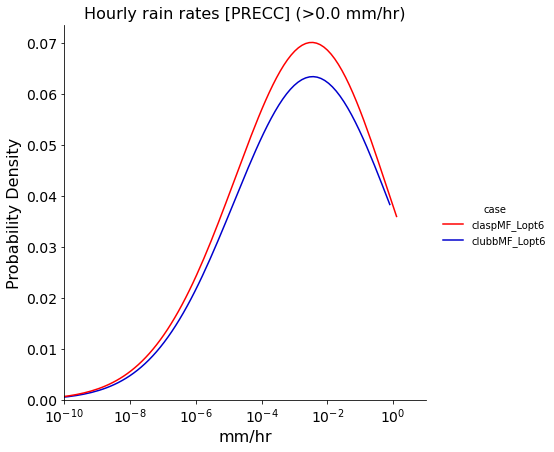

In [19]:
dfReal = pd.concat(axis=0, ignore_index=True, objs=[
         # pd.DataFrame.from_dict({'Rain rate': np.squeeze(rainRatesHTGrand_scam), 'case': 'claspMF_rand'}),
         pd.DataFrame.from_dict({'Rain rate': np.squeeze(rainRatesHTG_scam), 'case': 'claspMF_Lopt6'}),
         pd.DataFrame.from_dict({'Rain rate': np.squeeze(rainRatesHMG_scam), 'case': 'clubbMF_Lopt6'}),
         ])

# Make plot 
g = sns.displot(dfReal, x='Rain rate', hue='case', kind='kde', height=6, cut=0, 
                log_scale=True,
# g = sns.displot(dfReal, x='Rain rate', hue='case', kind='ecdf', height=8, 
                # palette=['limegreen','red','mediumblue'], legend=True)
                palette=['red','mediumblue'], legend=True)

g.ax.set_xlim([10**-10, 10**1])
g.ax.set_title("Hourly rain rates [PRECC] (>0.0 mm/hr)", fontsize=16 ) 
g.ax.set_xlabel('mm/hr',fontsize=16)
g.ax.set_ylabel('Probability Density',fontsize=16)
g.ax.tick_params(axis='both', labelsize= 14)


[None, None, None, None]

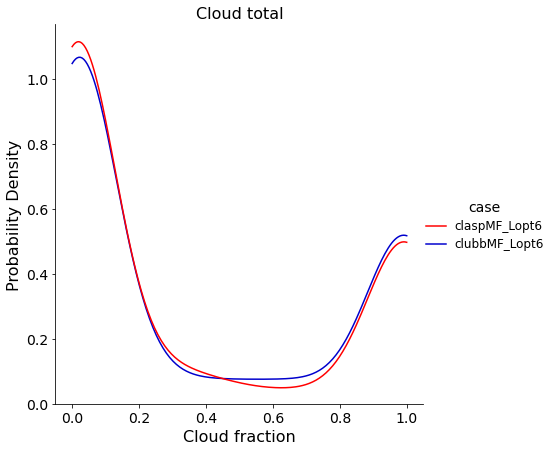

In [20]:
# scamCLD  = scamDS.CLDTOT.resample(time='1H').mean().dropna(dim='time')

scamCLD  = scamDaytime.CLDTOT.resample(time='1H').mean().dropna(dim='time')
# scamCLD  = scamDS.CLDTOT.resample(time='1H').mean().dropna(dim='time')
# # Limit to daytime hours
# selHours = np.where(scamCLD['time.hour'].values<=19)[0]
# scamCLD  = scamCLD.isel(time=selHours)

# SCAM
cldHMG_scam = scamCLD.sel(case='clubbMF_Lopt6').values
cldHTG_scam = scamCLD.sel(case='claspMF_Lopt6').values
# cldHTGrand_scam = scamCLD.sel(case='claspMF_L0eq250_rand').values

dfReal = pd.concat(axis=0, ignore_index=True, objs=[
         # pd.DataFrame.from_dict({'Cloud Fraction': np.squeeze(cldHTGrand_scam), 'case': 'claspMF_rand'}),
         pd.DataFrame.from_dict({'Cloud Fraction': np.squeeze(cldHTG_scam), 'case': 'claspMF_Lopt6'}),
         pd.DataFrame.from_dict({'Cloud Fraction': np.squeeze(cldHMG_scam), 'case': 'clubbMF_Lopt6'}),
         ])

# Make plot 
g = sns.displot(dfReal, x='Cloud Fraction', hue='case', kind='kde', height=6, cut=0,
                palette=['red','mediumblue'])

g.ax.set_title("Cloud total", fontsize=16 ) 
g.ax.set_xlabel('Cloud fraction',fontsize=16)
g.ax.set_ylabel('Probability Density',fontsize=16)
g.ax.tick_params(axis='both', labelsize= 14)

plt.setp(g._legend.get_title(), fontsize=14)
plt.setp(g._legend.get_texts(), fontsize=12)


Text(0, 0.5, 'Hourly Mean PRECC [mm/hr]')

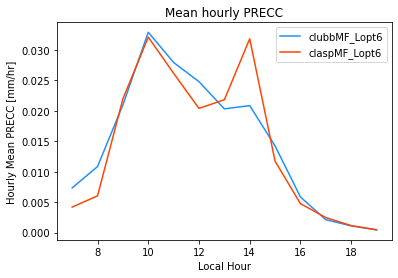

In [21]:
# SCAM
rainRatesHMG_scam = scamRain.sel(case='clubbMF_Lopt6').groupby('time.hour').mean(dim='time').dropna(dim='hour')
rainRatesHTG_scam = scamRain.sel(case='claspMF_Lopt6').groupby('time.hour').mean(dim='time').dropna(dim='hour')
# rainRatesHTGrand_scam = scamRain.sel(case='claspMF_L0eq250_rand').groupby('time.hour').mean(dim='time').dropna(dim='hour')

plt.plot(rainRatesHMG_scam.hour.values, 
         rainRatesHMG_scam.values, color='dodgerblue')

plt.plot(rainRatesHTG_scam.hour.values, 
         rainRatesHTG_scam.values, color='orangered')

# plt.plot(rainRatesHTGrand_scam.hour.values, 
#          rainRatesHTGrand_scam.values, color='limegreen')

plt.title('Mean hourly PRECC')
# plt.legend(['clubbMF','clasp+MF', 'clasp+MF_rand'])
plt.legend(['clubbMF_Lopt6','claspMF_Lopt6'])
plt.xlabel('Local Hour')
plt.ylabel('Hourly Mean PRECC [mm/hr]')

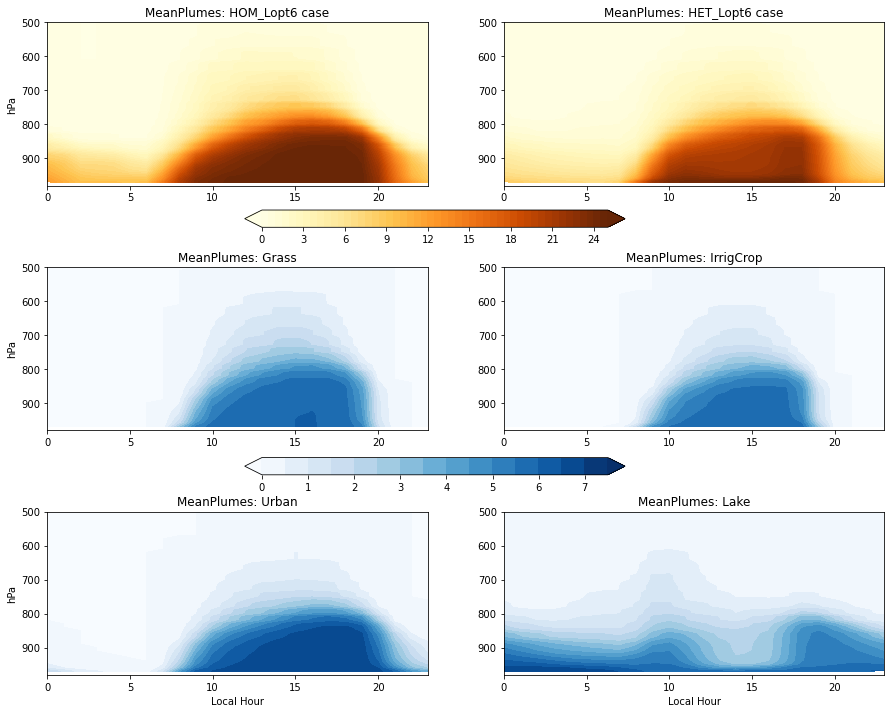

In [26]:
## Look at diurnal cycle of plume initiations?
nplumes_grassMean  = scamDS.sel(case='claspMF_Lopt6').nPlumesActive_grass.resample(time='1H').mean().dropna(dim='time').groupby('time.hour').mean(dim='time')
nplumes_cropMean   = scamDS.sel(case='claspMF_Lopt6').nPlumesActive_crop.resample(time='1H').mean().dropna(dim='time').groupby('time.hour').mean(dim='time')
nplumes_urbanMean  = scamDS.sel(case='claspMF_Lopt6').nPlumesActive_urban.resample(time='1H').mean().dropna(dim='time').groupby('time.hour').mean(dim='time')
nplumes_lakeMean   = scamDS.sel(case='claspMF_Lopt6').nPlumesActive_lake.resample(time='1H').mean().dropna(dim='time').groupby('time.hour').mean(dim='time')

nplumes_HOMmean    = scamDS.sel(case='clubbMF_Lopt6').nPlumesActive.resample(time='1H').mean().dropna(dim='time').groupby('time.hour').mean(dim='time')
nplumes_HETmean    = scamDS.sel(case='claspMF_Lopt6').nPlumesActive.resample(time='1H').mean().dropna(dim='time').groupby('time.hour').mean(dim='time')

## ----- Plot that ----- 
fig,axs = plt.subplots(3,2, figsize=(15,12))
axs = axs.ravel()

## Plot overall means 
axs[0].contourf(nplumes_HOMmean.hour.values, nplumes_HOMmean.levInterp.values, 
                nplumes_HOMmean.values.transpose(), np.arange(0,25.5,0.5), 
                cmap = 'YlOrBr', extend='both')
axs[0].set_title('MeanPlumes: HOM_Lopt6 case')

cplot = axs[1].contourf(nplumes_HETmean.hour.values, nplumes_HETmean.levInterp.values, 
                nplumes_HETmean.values.transpose(), np.arange(0,25.5,0.5), 
                cmap = 'YlOrBr', extend='both')
axs[1].set_title('MeanPlumes: HET_Lopt6 case')

# add colorbar for overall mean cases 
ax_position = axs[1].get_position()
cbar_ax = fig.add_axes([ax_position.x0-0.24, ax_position.y0-0.015, ax_position.width, 0.02])
cbar = plt.colorbar(cplot, orientation='horizontal',cax=cbar_ax)


## Plot patch data 
axs[2].contourf(nplumes_grassMean.hour.values, nplumes_grassMean.levInterp.values, 
                nplumes_grassMean.values.transpose(), np.arange(0,8,0.5), 
                cmap = 'Blues', extend='both')
axs[2].set_title('MeanPlumes: Grass')

cplot=axs[3].contourf(nplumes_cropMean.hour.values, nplumes_cropMean.levInterp.values, 
                nplumes_cropMean.values.transpose(), np.arange(0,8,0.5), 
                cmap = 'Blues', extend='both')
axs[3].set_title('MeanPlumes: IrrigCrop')
# add colorbar for individual patches 
ax_position = axs[3].get_position()
cbar_ax = fig.add_axes([ax_position.x0-0.24, ax_position.y0-0.035, ax_position.width, 0.02])
cbar = plt.colorbar(cplot, orientation='horizontal',cax=cbar_ax)

axs[4].contourf(nplumes_urbanMean.hour.values, nplumes_urbanMean.levInterp.values, 
                nplumes_urbanMean.values.transpose(), np.arange(0,8,0.5), 
                cmap = 'Blues', extend='both')
axs[4].set_title('MeanPlumes: Urban')

cplot = axs[5].contourf(nplumes_lakeMean.hour.values, nplumes_lakeMean.levInterp.values, 
                nplumes_lakeMean.values.transpose(), np.arange(0,8,0.5), 
                cmap = 'Blues', extend='both')
axs[5].set_title('MeanPlumes: Lake')


## Other plot options 
axs[0].invert_yaxis()
axs[1].invert_yaxis()
axs[2].invert_yaxis()
axs[3].invert_yaxis()
axs[4].invert_yaxis()
axs[5].invert_yaxis()

axs[0].set_ylim([980,500])
axs[1].set_ylim([980,500])
axs[2].set_ylim([980,500])
axs[3].set_ylim([980,500])
axs[4].set_ylim([980,500])
axs[5].set_ylim([980,500])

axs[4].set_xlabel('Local Hour')
axs[5].set_xlabel('Local Hour')

axs[0].set_ylabel('hPa')
axs[2].set_ylabel('hPa')
axs[4].set_ylabel('hPa')

fig.subplots_adjust(hspace = 0.5)


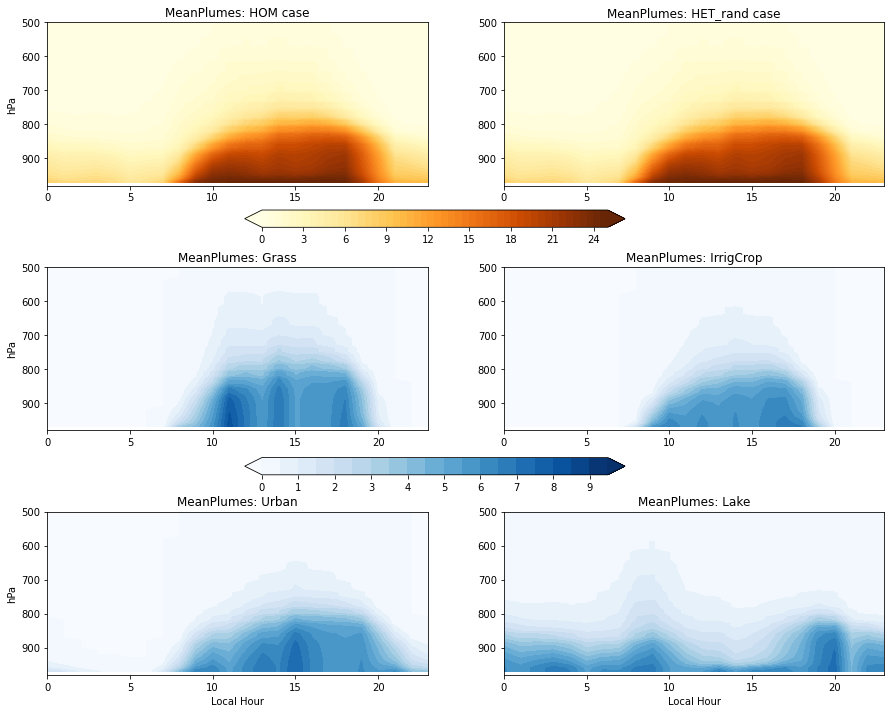

In [54]:
# ## Look at diurnal cycle of plume initiations?
# nplumes_grassMean  = scamDS.sel(case='claspMF_L0eq250_rand').nPlumesActive_grass.resample(time='1H').mean().dropna(dim='time').groupby('time.hour').mean(dim='time')
# nplumes_cropMean   = scamDS.sel(case='claspMF_L0eq250_rand').nPlumesActive_crop.resample(time='1H').mean().dropna(dim='time').groupby('time.hour').mean(dim='time')
# nplumes_urbanMean  = scamDS.sel(case='claspMF_L0eq250_rand').nPlumesActive_urban.resample(time='1H').mean().dropna(dim='time').groupby('time.hour').mean(dim='time')
# nplumes_lakeMean   = scamDS.sel(case='claspMF_L0eq250_rand').nPlumesActive_lake.resample(time='1H').mean().dropna(dim='time').groupby('time.hour').mean(dim='time')

# nplumes_HOMmean    = scamDS.sel(case='claspMF_L0eq250_rand').nPlumesActive.resample(time='1H').mean().dropna(dim='time').groupby('time.hour').mean(dim='time')
# nplumes_HETmean    = scamDS.sel(case='claspMF_L0eq250_rand').nPlumesActive.resample(time='1H').mean().dropna(dim='time').groupby('time.hour').mean(dim='time')

# ## ----- Plot that ----- 
# fig,axs = plt.subplots(3,2, figsize=(15,12))
# axs = axs.ravel()

# ## Plot overall means 
# axs[0].contourf(nplumes_HOMmean.hour.values, nplumes_HOMmean.levInterp.values, 
#                 nplumes_HOMmean.values.transpose(), np.arange(0,25.5,0.5), 
#                 cmap = 'YlOrBr', extend='both')
# axs[0].set_title('MeanPlumes: HOM case')

# cplot = axs[1].contourf(nplumes_HETmean.hour.values, nplumes_HETmean.levInterp.values, 
#                 nplumes_HETmean.values.transpose(), np.arange(0,25.5,0.5), 
#                 cmap = 'YlOrBr', extend='both')
# axs[1].set_title('MeanPlumes: HET_rand case')

# # add colorbar for overall mean cases 
# ax_position = axs[1].get_position()
# cbar_ax = fig.add_axes([ax_position.x0-0.24, ax_position.y0-0.015, ax_position.width, 0.02])
# cbar = plt.colorbar(cplot, orientation='horizontal',cax=cbar_ax)


# ## Plot patch data 
# axs[2].contourf(nplumes_grassMean.hour.values, nplumes_grassMean.levInterp.values, 
#                 nplumes_grassMean.values.transpose(), np.arange(0,10,0.5), 
#                 cmap = 'Blues', extend='both')
# axs[2].set_title('MeanPlumes: Grass')

# cplot=axs[3].contourf(nplumes_cropMean.hour.values, nplumes_cropMean.levInterp.values, 
#                 nplumes_cropMean.values.transpose(), np.arange(0,10,0.5), 
#                 cmap = 'Blues', extend='both')
# axs[3].set_title('MeanPlumes: IrrigCrop')
# # add colorbar for individual patches 
# ax_position = axs[3].get_position()
# cbar_ax = fig.add_axes([ax_position.x0-0.24, ax_position.y0-0.035, ax_position.width, 0.02])
# cbar = plt.colorbar(cplot, orientation='horizontal',cax=cbar_ax)

# axs[4].contourf(nplumes_urbanMean.hour.values, nplumes_urbanMean.levInterp.values, 
#                 nplumes_urbanMean.values.transpose(), np.arange(0,10,0.5), 
#                 cmap = 'Blues', extend='both')
# axs[4].set_title('MeanPlumes: Urban')

# cplot = axs[5].contourf(nplumes_lakeMean.hour.values, nplumes_lakeMean.levInterp.values, 
#                 nplumes_lakeMean.values.transpose(), np.arange(0,10,0.5), 
#                 cmap = 'Blues', extend='both')
# axs[5].set_title('MeanPlumes: Lake')


# ## Other plot options 
# axs[0].invert_yaxis()
# axs[1].invert_yaxis()
# axs[2].invert_yaxis()
# axs[3].invert_yaxis()
# axs[4].invert_yaxis()
# axs[5].invert_yaxis()

# axs[0].set_ylim([980,500])
# axs[1].set_ylim([980,500])
# axs[2].set_ylim([980,500])
# axs[3].set_ylim([980,500])
# axs[4].set_ylim([980,500])
# axs[5].set_ylim([980,500])

# axs[4].set_xlabel('Local Hour')
# axs[5].set_xlabel('Local Hour')

# axs[0].set_ylabel('hPa')
# axs[2].set_ylabel('hPa')
# axs[4].set_ylabel('hPa')

# fig.subplots_adjust(hspace = 0.5)


In [18]:
test     = grassDS.up_macmicAvg_interp.isel(time=150, levInterp=-1)
unweighted_mean = test.mean(dim='nens')
weights  = grassDS.upa_macmicAvg_interp.isel(time=150, levInterp=-1).fillna(0)

test_weighted = test.weighted(weights) 
weighted_mean = test_weighted.mean(dim='nens')

print('Unweighted mean: ', unweighted_mean.values)
print('Weighted mean:   ', weighted_mean.values)

Unweighted mean:  [       nan 2.08376815]
Weighted mean:    [       nan 1.91707551]


In [56]:
## Sanity check that the weighted mean calculation is going to work as expected.... 
test     = grassDS.up_macmicAvg_interp.isel(time=150, levInterp=-1)
unweighted_mean = test.mean(dim='nens')
weights  = grassDS.upa_macmicAvg_interp.isel(time=150, levInterp=-1).fillna(0)

test_weighted = test.weighted(weights) 
weighted_mean = test_weighted.mean(dim='nens')

print('Unweighted mean: ', unweighted_mean.values)
print('Weighted mean:   ', weighted_mean.values)


wgtMean=0.0
sumWgts = 0.0 

for iVal in range(len(test.values)): 
    wgtMean = np.nansum([wgtMean, (grassDS.upa_macmicAvg_interp.isel(time=150, levInterp=-1).values[iVal]*grassDS.up_macmicAvg_interp.isel(time=150, levInterp=-1).values[iVal]) ])
    sumWgts = np.nansum([sumWgts, grassDS.upa_macmicAvg_interp.isel(time=150, levInterp=-1).values[iVal]])
wgtMean = wgtMean/sumWgts 

print('Manually calculate weighted mean: ', wgtMean)

Unweighted mean:  2.0837681476961496
Weighted mean:    1.917075511272616
Manually calculate weighted mean:  1.917075511272616


In [57]:
weights = grassDS.upa_macmicAvg_interp.fillna(0)
testWeighted= grassDS.up_macmicAvg_interp.weighted(weights).mean(dim='nens')
print(testWeighted.isel(time=150, levInterp=-1).values)

1.917075511272616


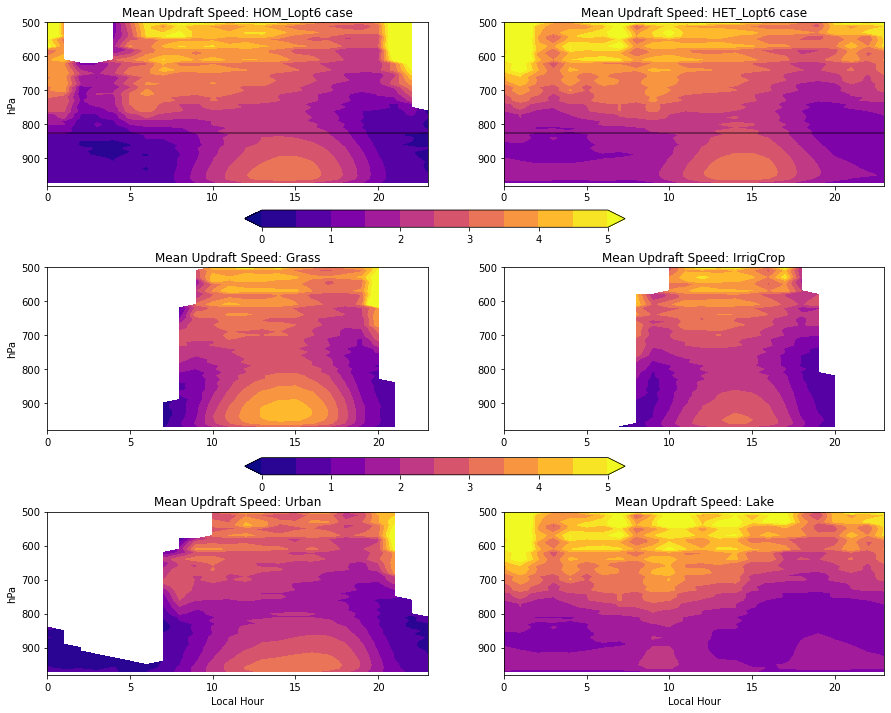

In [23]:
# varToPlot = 'edmf_upw_interp'
varToPlot = 'up_macmicAvg_interp'

# Look at diurnal cycle of plume initiations?
nplumes_grassMean  = grassDS[varToPlot].sel(case='claspMF_Lopt6').weighted(grassDS.sel(case='claspMF_Lopt6').upa_macmicAvg_interp.fillna(0)).mean(dim='nens').resample(time='1H').mean().groupby('time.hour').mean(dim='time')
nplumes_cropMean   = cropDS[varToPlot].sel(case='claspMF_Lopt6').weighted(cropDS.sel(case='claspMF_Lopt6').upa_macmicAvg_interp.fillna(0)).mean(dim='nens').resample(time='1H').mean().groupby('time.hour').mean(dim='time')
nplumes_urbanMean  = urbanDS[varToPlot].sel(case='claspMF_Lopt6').weighted(urbanDS.sel(case='claspMF_Lopt6').upa_macmicAvg_interp.fillna(0)).mean(dim='nens').resample(time='1H').mean().groupby('time.hour').mean(dim='time')
nplumes_lakeMean   = lakeDS[varToPlot].sel(case='claspMF_Lopt6').weighted(lakeDS.sel(case='claspMF_Lopt6').upa_macmicAvg_interp.fillna(0)).mean(dim='nens').resample(time='1H').mean().groupby('time.hour').mean(dim='time')

HOMwgts = scamDS_h2.upa_macmicAvg_interp.sel(case='clubbMF_Lopt6').fillna(0)
HETwgts = scamDS_h2.upa_macmicAvg_interp.sel(case='claspMF_Lopt6').fillna(0)
nplumes_HOMmean    = scamDS_h2[varToPlot].sel(case='clubbMF_Lopt6').weighted(HOMwgts).mean(dim='nens').resample(time='1H').mean().groupby('time.hour').mean(dim='time')
nplumes_HETmean    = scamDS_h2[varToPlot].sel(case='claspMF_Lopt6').weighted(HETwgts).mean(dim='nens').resample(time='1H').mean().groupby('time.hour').mean(dim='time')


## ----- Plot that ----- 
fig,axs = plt.subplots(3,2, figsize=(15,12))
axs = axs.ravel()

## Plot overall means 
axs[0].contourf(nplumes_HOMmean.hour.values, nplumes_HOMmean.levInterp.values, 
                nplumes_HOMmean.values.transpose(), np.arange(0,5.5,0.5), 
                cmap = 'plasma', extend='both')
axs[0].set_title('Mean Updraft Speed: HOM_Lopt6 case')

cplot = axs[1].contourf(nplumes_HETmean.hour.values, nplumes_HETmean.levInterp.values, 
                nplumes_HETmean.values.transpose(), np.arange(0,5.5,0.5), 
                cmap = 'plasma', extend='both')
axs[1].set_title('Mean Updraft Speed: HET_Lopt6 case')

# add colorbar for overall mean cases 
ax_position = axs[1].get_position()
cbar_ax = fig.add_axes([ax_position.x0-0.24, ax_position.y0-0.015, ax_position.width, 0.02])
cbar = plt.colorbar(cplot, orientation='horizontal',cax=cbar_ax)


## Plot patch data 
axs[2].contourf(nplumes_grassMean.hour.values, nplumes_grassMean.levInterp.values, 
                nplumes_grassMean.values.transpose(), np.arange(0,5.5,0.5), 
                cmap = 'plasma', extend='both')
axs[2].set_title('Mean Updraft Speed: Grass')

cplot=axs[3].contourf(nplumes_cropMean.hour.values, nplumes_cropMean.levInterp.values, 
                nplumes_cropMean.values.transpose(), np.arange(0,5.5,0.5), 
                cmap = 'plasma', extend='both')
axs[3].set_title('Mean Updraft Speed: IrrigCrop')
# add colorbar for individual patches 
ax_position = axs[3].get_position()
cbar_ax = fig.add_axes([ax_position.x0-0.24, ax_position.y0-0.035, ax_position.width, 0.02])
cbar = plt.colorbar(cplot, orientation='horizontal',cax=cbar_ax)

axs[4].contourf(nplumes_urbanMean.hour.values, nplumes_urbanMean.levInterp.values, 
                nplumes_urbanMean.values.transpose(), np.arange(0,5.5,0.5), 
                cmap = 'plasma', extend='both')
axs[4].set_title('Mean Updraft Speed: Urban')

cplot = axs[5].contourf(nplumes_lakeMean.hour.values, nplumes_lakeMean.levInterp.values, 
                nplumes_lakeMean.values.transpose(), np.arange(0,5.5,0.5), 
                cmap = 'plasma', extend='both')
axs[5].set_title('Mean Updraft Speed: Lake')


## Other plot options 
axs[0].invert_yaxis()
axs[1].invert_yaxis()
axs[2].invert_yaxis()
axs[3].invert_yaxis()
axs[4].invert_yaxis()
axs[5].invert_yaxis()

axs[0].set_ylim([980,500])
axs[1].set_ylim([980,500])
axs[2].set_ylim([980,500])
axs[3].set_ylim([980,500])
axs[4].set_ylim([980,500])
axs[5].set_ylim([980,500])

# axs[0].set_xlim([7,19])
# axs[1].set_xlim([7,19])
# axs[2].set_xlim([7,19])
# axs[3].set_xlim([7,19])
# axs[4].set_xlim([7,19])
# axs[5].set_xlim([7,19])

axs[4].set_xlabel('Local Hour')
axs[5].set_xlabel('Local Hour')

axs[0].set_ylabel('hPa')
axs[2].set_ylabel('hPa')
axs[4].set_ylabel('hPa')

axs[0].axhline(825,color='k',alpha=0.5)
axs[1].axhline(825,color='k',alpha=0.5)

fig.subplots_adjust(hspace = 0.5)


In [ ]:
# # varToPlot = 'edmf_upw_interp'
# varToPlot = 'up_macmicAvg_interp'

# # Look at diurnal cycle of plume initiations?
# nplumes_grassMean  = grassDS[varToPlot].sel(case='claspMF_L0eq250_rand').weighted(grassDS.sel(case='claspMF_L0eq250_rand').upa_macmicAvg_interp.fillna(0)).mean(dim='nens').resample(time='1H').mean().groupby('time.hour').mean(dim='time')
# nplumes_cropMean   = cropDS[varToPlot].sel(case='claspMF_L0eq250_rand').weighted(cropDS.sel(case='claspMF_L0eq250_rand').upa_macmicAvg_interp.fillna(0)).mean(dim='nens').resample(time='1H').mean().groupby('time.hour').mean(dim='time')
# nplumes_urbanMean  = urbanDS[varToPlot].sel(case='claspMF_L0eq250_rand').weighted(urbanDS.sel(case='claspMF_L0eq250_rand').upa_macmicAvg_interp.fillna(0)).mean(dim='nens').resample(time='1H').mean().groupby('time.hour').mean(dim='time')
# nplumes_lakeMean   = lakeDS[varToPlot].sel(case='claspMF_L0eq250_rand').weighted(lakeDS.sel(case='claspMF_L0eq250_rand').upa_macmicAvg_interp.fillna(0)).mean(dim='nens').resample(time='1H').mean().groupby('time.hour').mean(dim='time')

# HOMwgts = scamDS_h2.upa_macmicAvg_interp.sel(case='clubbMF_L0eq250').fillna(0)
# HETwgts = scamDS_h2.upa_macmicAvg_interp.sel(case='claspMF_L0eq250_rand').fillna(0)
# nplumes_HOMmean    = scamDS_h2[varToPlot].sel(case='clubbMF_L0eq250').weighted(HOMwgts).mean(dim='nens').resample(time='1H').mean().groupby('time.hour').mean(dim='time')
# nplumes_HETmean    = scamDS_h2[varToPlot].sel(case='claspMF_L0eq250_rand').weighted(HETwgts).mean(dim='nens').resample(time='1H').mean().groupby('time.hour').mean(dim='time')


# ## ----- Plot that ----- 
# fig,axs = plt.subplots(3,2, figsize=(15,12))
# axs = axs.ravel()

# ## Plot overall means 
# axs[0].contourf(nplumes_HOMmean.hour.values, nplumes_HOMmean.levInterp.values, 
#                 nplumes_HOMmean.values.transpose(), np.arange(0,5.5,0.5), 
#                 cmap = 'plasma', extend='both')
# axs[0].set_title('Mean Updraft Speed: HOM case')

# cplot = axs[1].contourf(nplumes_HETmean.hour.values, nplumes_HETmean.levInterp.values, 
#                 nplumes_HETmean.values.transpose(), np.arange(0,5.5,0.5), 
#                 cmap = 'plasma', extend='both')
# axs[1].set_title('Mean Updraft Speed: HET_rand case')

# # add colorbar for overall mean cases 
# ax_position = axs[1].get_position()
# cbar_ax = fig.add_axes([ax_position.x0-0.24, ax_position.y0-0.015, ax_position.width, 0.02])
# cbar = plt.colorbar(cplot, orientation='horizontal',cax=cbar_ax)


# ## Plot patch data 
# axs[2].contourf(nplumes_grassMean.hour.values, nplumes_grassMean.levInterp.values, 
#                 nplumes_grassMean.values.transpose(), np.arange(0,5.5,0.5), 
#                 cmap = 'plasma', extend='both')
# axs[2].set_title('Mean Updraft Speed: Grass')

# cplot=axs[3].contourf(nplumes_cropMean.hour.values, nplumes_cropMean.levInterp.values, 
#                 nplumes_cropMean.values.transpose(), np.arange(0,5.5,0.5), 
#                 cmap = 'plasma', extend='both')
# axs[3].set_title('Mean Updraft Speed: IrrigCrop')
# # add colorbar for individual patches 
# ax_position = axs[3].get_position()
# cbar_ax = fig.add_axes([ax_position.x0-0.24, ax_position.y0-0.035, ax_position.width, 0.02])
# cbar = plt.colorbar(cplot, orientation='horizontal',cax=cbar_ax)

# axs[4].contourf(nplumes_urbanMean.hour.values, nplumes_urbanMean.levInterp.values, 
#                 nplumes_urbanMean.values.transpose(), np.arange(0,5.5,0.5), 
#                 cmap = 'plasma', extend='both')
# axs[4].set_title('Mean Updraft Speed: Urban')

# cplot = axs[5].contourf(nplumes_lakeMean.hour.values, nplumes_lakeMean.levInterp.values, 
#                 nplumes_lakeMean.values.transpose(), np.arange(0,5.5,0.5), 
#                 cmap = 'plasma', extend='both')
# axs[5].set_title('Mean Updraft Speed: Lake')


# ## Other plot options 
# axs[0].invert_yaxis()
# axs[1].invert_yaxis()
# axs[2].invert_yaxis()
# axs[3].invert_yaxis()
# axs[4].invert_yaxis()
# axs[5].invert_yaxis()

# axs[0].set_ylim([980,500])
# axs[1].set_ylim([980,500])
# axs[2].set_ylim([980,500])
# axs[3].set_ylim([980,500])
# axs[4].set_ylim([980,500])
# axs[5].set_ylim([980,500])

# # axs[0].set_xlim([7,19])
# # axs[1].set_xlim([7,19])
# # axs[2].set_xlim([7,19])
# # axs[3].set_xlim([7,19])
# # axs[4].set_xlim([7,19])
# # axs[5].set_xlim([7,19])

# axs[4].set_xlabel('Local Hour')
# axs[5].set_xlabel('Local Hour')

# axs[0].set_ylabel('hPa')
# axs[2].set_ylabel('hPa')
# axs[4].set_ylabel('hPa')

# axs[0].axhline(825,color='k',alpha=0.5)
# axs[1].axhline(825,color='k',alpha=0.5)

# fig.subplots_adjust(hspace = 0.5)


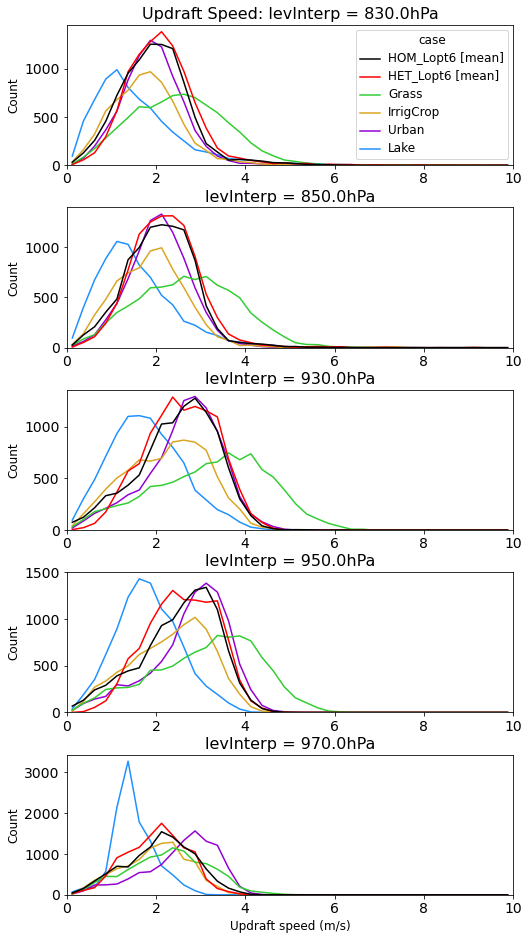

In [24]:
## Data choices 

varSel = 'up_macmicAvg_interp'
# levSel = [-25,-17,-15,-13,-11,-9,-7,-5,-3,-1]
levSel = [-15,-13,-5,-3,-1]

# Limit to daytime hours
selHours = np.where((scamDS_h2['time.hour'].values>=7) & (scamDS_h2['time.hour'].values<=19))[0]
# scamDay  = scamDS_h2.isel(time=selHours).mean(dim='nens')

edmf_grass = grassDS[varSel].sel(case='claspMF_Lopt6').isel(time=selHours).weighted(grassDS.sel(case='claspMF_Lopt6').upa_macmicAvg_interp.isel(time=selHours).fillna(0)).mean(dim='nens')
edmf_crop  = cropDS[varSel].sel(case='claspMF_Lopt6').isel(time=selHours).weighted(cropDS.sel(case='claspMF_Lopt6').upa_macmicAvg_interp.isel(time=selHours).fillna(0)).mean(dim='nens')
edmf_urban  = urbanDS[varSel].sel(case='claspMF_Lopt6').isel(time=selHours).weighted(urbanDS.sel(case='claspMF_Lopt6').upa_macmicAvg_interp.isel(time=selHours).fillna(0)).mean(dim='nens')
edmf_lake   = lakeDS[varSel].sel(case='claspMF_Lopt6').isel(time=selHours).weighted(lakeDS.sel(case='claspMF_Lopt6').upa_macmicAvg_interp.isel(time=selHours).fillna(0)).mean(dim='nens')

HOMwgts = scamDS_h2.upa_macmicAvg_interp.sel(case='clubbMF_Lopt6').isel(time=selHours).fillna(0)
HETwgts = scamDS_h2.upa_macmicAvg_interp.sel(case='claspMF_Lopt6').isel(time=selHours).fillna(0)
edmf_CTRL  = scamDS_h2[varSel].sel(case='clubbMF_Lopt6').isel(time=selHours).weighted(HOMwgts).mean(dim='nens')
edmf_HET   = scamDS_h2[varSel].sel(case='claspMF_Lopt6').isel(time=selHours).weighted(HETwgts).mean(dim='nens')


fig, axes = plt.subplots(5,1, figsize=(8,16))

## Make figures 
for ilev in range(len(levSel)):
    dfReal = pd.concat(axis=0, ignore_index=True, objs=[
         pd.DataFrame.from_dict({'UpdraftSpeed': np.squeeze(edmf_CTRL.isel(levInterp=levSel[ilev]).values), 'case': 'HOM_Lopt6 [mean]'}),
         pd.DataFrame.from_dict({'UpdraftSpeed': np.squeeze(edmf_HET.isel(levInterp=levSel[ilev]).values), 'case': 'HET_Lopt6 [mean]'}),

        pd.DataFrame.from_dict({'UpdraftSpeed': np.squeeze(edmf_grass.isel(levInterp=levSel[ilev]).values), 'case': 'Grass'}),
         pd.DataFrame.from_dict({'UpdraftSpeed': np.squeeze(edmf_crop.isel(levInterp=levSel[ilev]).values), 'case': 'IrrigCrop'}),
         pd.DataFrame.from_dict({'UpdraftSpeed': np.squeeze(edmf_urban.isel(levInterp=levSel[ilev]).values), 'case': 'Urban'}),
         pd.DataFrame.from_dict({'UpdraftSpeed': np.squeeze(edmf_lake.isel(levInterp=levSel[ilev]).values), 'case': 'Lake'}),
         ])


    if ilev==0:
        # g = sns.kdeplot( data=dfReal, x='UpdraftSpeed', hue='case', cut=0,
        # #                 fill=True, alpha=0.5,
        #                 common_norm = True,
        #                 palette=['k','red','limegreen','goldenrod','darkviolet','dodgerblue'],
        #                 # palette=['k','red'],
        #                # height=3, aspect=9/3, 
        #                ax = axes[ilev]
        #                )
        g = sns.histplot( data=dfReal, x='UpdraftSpeed', hue='case',
                         stat = 'count',
                         binwidth=0.25,
                         binrange=[0,10],
                         element='poly',
                         fill=False,
                        palette=['k','red','limegreen','goldenrod','darkviolet','dodgerblue'],
                        # palette=['k','red','limegreen','dodgerblue'],
                       # height=3, aspect=9/3, 
                       ax = axes[ilev]
                       )
    else:
        g = sns.histplot( data=dfReal, x='UpdraftSpeed', hue='case',
                         stat = 'count',
                         binwidth=0.25,
                         binrange=[0,10],
                         element='poly',
                         fill=False,
                         legend=False,
                        palette=['k','red','limegreen','goldenrod','darkviolet','dodgerblue'],
                        # palette=['k','red','limegreen','dodgerblue'],
                       # height=3, aspect=9/3, 
                       ax = axes[ilev],
                       )
        
        
    if ilev==0:
        axes[ilev].set_title("Updraft Speed: levInterp = "+str(edmf_CTRL.levInterp.values[levSel[ilev]])+'hPa', fontsize=16 )
        plt.setp(g.legend_.get_title(), fontsize=12)
        plt.setp(g.legend_.get_texts(), fontsize=12)
    else:
        axes[ilev].set_title("levInterp = "+str(edmf_CTRL.levInterp.values[levSel[ilev]])+'hPa', fontsize=16 ) 

        
    if ilev==len(levSel)-1:
        axes[ilev].set_xlabel('Updraft speed (m/s)',fontsize=12)
    else:
        axes[ilev].set_xlabel('')
        
    # axes[ilev].set_ylabel('Probability Density',fontsize=12)
    axes[ilev].set_ylabel('Count',fontsize=12)
    axes[ilev].set_xlim([0.00, 10])
    # axes[ilev].set_ylim([0.0, 0.45])

    axes[ilev].tick_params(axis='both', labelsize= 14)



fig.subplots_adjust(hspace=0.3)

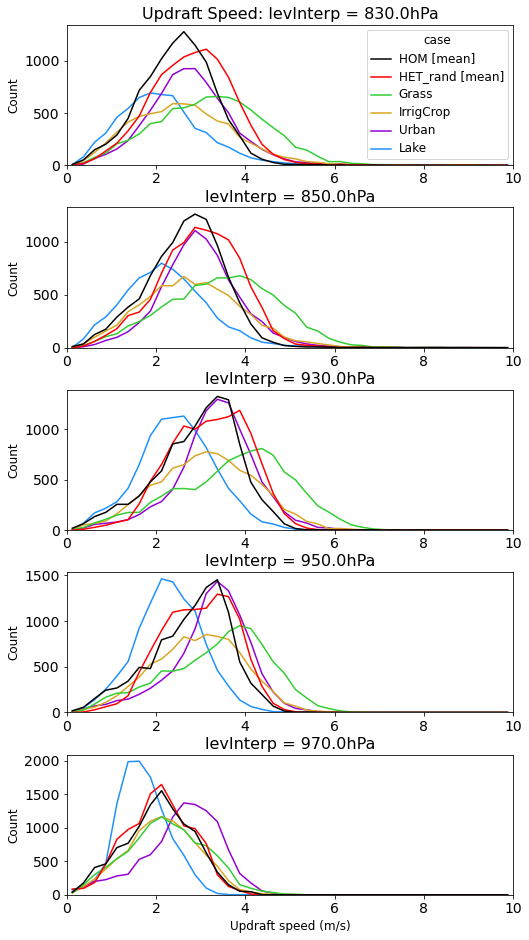

In [21]:
# ## Data choices 

# varSel = 'up_macmicAvg_interp'
# # levSel = [-25,-17,-15,-13,-11,-9,-7,-5,-3,-1]
# levSel = [-15,-13,-5,-3,-1]

# # Limit to daytime hours
# selHours = np.where((scamDS_h2['time.hour'].values>=7) & (scamDS_h2['time.hour'].values<=19))[0]
# # scamDay  = scamDS_h2.isel(time=selHours).mean(dim='nens')

# edmf_grass = grassDS[varSel].sel(case='claspMF_L0eq250_rand').isel(time=selHours).weighted(grassDS.sel(case='claspMF_L0eq250_rand').upa_macmicAvg_interp.isel(time=selHours).fillna(0)).mean(dim='nens')
# edmf_crop  = cropDS[varSel].sel(case='claspMF_L0eq250_rand').isel(time=selHours).weighted(cropDS.sel(case='claspMF_L0eq250_rand').upa_macmicAvg_interp.isel(time=selHours).fillna(0)).mean(dim='nens')
# edmf_urban  = urbanDS[varSel].sel(case='claspMF_L0eq250_rand').isel(time=selHours).weighted(urbanDS.sel(case='claspMF_L0eq250_rand').upa_macmicAvg_interp.isel(time=selHours).fillna(0)).mean(dim='nens')
# edmf_lake   = lakeDS[varSel].sel(case='claspMF_L0eq250_rand').isel(time=selHours).weighted(lakeDS.sel(case='claspMF_L0eq250_rand').upa_macmicAvg_interp.isel(time=selHours).fillna(0)).mean(dim='nens')

# HOMwgts = scamDS_h2.upa_macmicAvg_interp.sel(case='clubbMF_L0eq250').isel(time=selHours).fillna(0)
# HETwgts = scamDS_h2.upa_macmicAvg_interp.sel(case='claspMF_L0eq250_rand').isel(time=selHours).fillna(0)
# edmf_CTRL  = scamDS_h2[varSel].sel(case='clubbMF_L0eq250').isel(time=selHours).weighted(HOMwgts).mean(dim='nens')
# edmf_HET   = scamDS_h2[varSel].sel(case='claspMF_L0eq250_rand').isel(time=selHours).weighted(HETwgts).mean(dim='nens')


# fig, axes = plt.subplots(5,1, figsize=(8,16))

# ## Make figures 
# for ilev in range(len(levSel)):
#     dfReal = pd.concat(axis=0, ignore_index=True, objs=[
#          pd.DataFrame.from_dict({'UpdraftSpeed': np.squeeze(edmf_CTRL.isel(levInterp=levSel[ilev]).values), 'case': 'HOM [mean]'}),
#          pd.DataFrame.from_dict({'UpdraftSpeed': np.squeeze(edmf_HET.isel(levInterp=levSel[ilev]).values), 'case': 'HET_rand [mean]'}),

#         pd.DataFrame.from_dict({'UpdraftSpeed': np.squeeze(edmf_grass.isel(levInterp=levSel[ilev]).values), 'case': 'Grass'}),
#          pd.DataFrame.from_dict({'UpdraftSpeed': np.squeeze(edmf_crop.isel(levInterp=levSel[ilev]).values), 'case': 'IrrigCrop'}),
#          pd.DataFrame.from_dict({'UpdraftSpeed': np.squeeze(edmf_urban.isel(levInterp=levSel[ilev]).values), 'case': 'Urban'}),
#          pd.DataFrame.from_dict({'UpdraftSpeed': np.squeeze(edmf_lake.isel(levInterp=levSel[ilev]).values), 'case': 'Lake'}),
#          ])


#     if ilev==0:
#         # g = sns.kdeplot( data=dfReal, x='UpdraftSpeed', hue='case', cut=0,
#         # #                 fill=True, alpha=0.5,
#         #                 common_norm = True,
#         #                 palette=['k','red','limegreen','goldenrod','darkviolet','dodgerblue'],
#         #                 # palette=['k','red'],
#         #                # height=3, aspect=9/3, 
#         #                ax = axes[ilev]
#         #                )
#         g = sns.histplot( data=dfReal, x='UpdraftSpeed', hue='case',
#                          stat = 'count',
#                          binwidth=0.25,
#                          binrange=[0,10],
#                          element='poly',
#                          fill=False,
#                         palette=['k','red','limegreen','goldenrod','darkviolet','dodgerblue'],
#                         # palette=['k','red','limegreen','dodgerblue'],
#                        # height=3, aspect=9/3, 
#                        ax = axes[ilev]
#                        )
#     else:
#         g = sns.histplot( data=dfReal, x='UpdraftSpeed', hue='case',
#                          stat = 'count',
#                          binwidth=0.25,
#                          binrange=[0,10],
#                          element='poly',
#                          fill=False,
#                          legend=False,
#                         palette=['k','red','limegreen','goldenrod','darkviolet','dodgerblue'],
#                         # palette=['k','red','limegreen','dodgerblue'],
#                        # height=3, aspect=9/3, 
#                        ax = axes[ilev],
#                        )
        
        
#     if ilev==0:
#         axes[ilev].set_title("Updraft Speed: levInterp = "+str(edmf_CTRL.levInterp.values[levSel[ilev]])+'hPa', fontsize=16 )
#         plt.setp(g.legend_.get_title(), fontsize=12)
#         plt.setp(g.legend_.get_texts(), fontsize=12)
#     else:
#         axes[ilev].set_title("levInterp = "+str(edmf_CTRL.levInterp.values[levSel[ilev]])+'hPa', fontsize=16 ) 

        
#     if ilev==len(levSel)-1:
#         axes[ilev].set_xlabel('Updraft speed (m/s)',fontsize=12)
#     else:
#         axes[ilev].set_xlabel('')
        
#     # axes[ilev].set_ylabel('Probability Density',fontsize=12)
#     axes[ilev].set_ylabel('Count',fontsize=12)
#     axes[ilev].set_xlim([0.00, 10])
#     # axes[ilev].set_ylim([0.0, 0.45])

#     axes[ilev].tick_params(axis='both', labelsize= 14)



# fig.subplots_adjust(hspace=0.3)

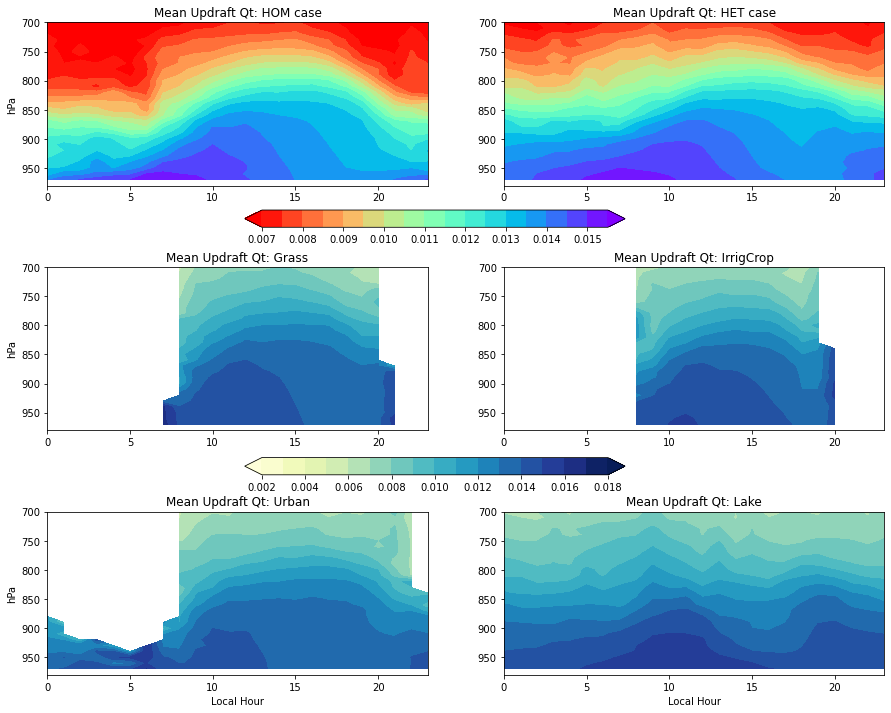

In [38]:
# ## Look at diurnal cycle of plume properties?
# varToPlot =  'qtu_macmicAvg_interp'

# # Look at diurnal cycle of plume initiations?
# nplumes_grassMean  = grassDS[varToPlot].weighted(grassDS.upa_macmicAvg_interp.fillna(0)).mean(dim='nens').resample(time='1H').mean().groupby('time.hour').mean(dim='time')
# nplumes_cropMean   = cropDS[varToPlot].weighted(cropDS.upa_macmicAvg_interp.fillna(0)).mean(dim='nens').resample(time='1H').mean().groupby('time.hour').mean(dim='time')
# nplumes_urbanMean  = urbanDS[varToPlot].weighted(urbanDS.upa_macmicAvg_interp.fillna(0)).mean(dim='nens').resample(time='1H').mean().groupby('time.hour').mean(dim='time')
# nplumes_lakeMean   = lakeDS[varToPlot].weighted(lakeDS.upa_macmicAvg_interp.fillna(0)).mean(dim='nens').resample(time='1H').mean().groupby('time.hour').mean(dim='time')

# HOMwgts = scamDS_h2.upa_macmicAvg_interp.sel(case='clubbMF_L0eq250').fillna(0)
# HETwgts = scamDS_h2.upa_macmicAvg_interp.sel(case='claspMF_L0eq250').fillna(0)
# nplumes_HOMmean    = scamDS_h2[varToPlot].sel(case='clubbMF_L0eq250').weighted(HOMwgts).mean(dim='nens').resample(time='1H').mean().groupby('time.hour').mean(dim='time')
# nplumes_HETmean    = scamDS_h2[varToPlot].sel(case='claspMF_L0eq250').weighted(HETwgts).mean(dim='nens').resample(time='1H').mean().groupby('time.hour').mean(dim='time')


# ## ----- Plot that ----- 
# fig,axs = plt.subplots(3,2, figsize=(15,12))
# axs = axs.ravel()

# ## Plot overall means 
# axs[0].contourf(nplumes_HOMmean.hour.values, nplumes_HOMmean.levInterp.values, 
#                 nplumes_HOMmean.values.transpose(), np.arange(0.007,0.016,0.0005), 
#                 cmap = 'rainbow_r', extend='both')
# axs[0].set_title('Mean Updraft Qt: HOM case')

# cplot = axs[1].contourf(nplumes_HETmean.hour.values, nplumes_HETmean.levInterp.values, 
#                 nplumes_HETmean.values.transpose(), np.arange(0.007,0.016,0.0005), 
#                 cmap = 'rainbow_r', extend='both')
# axs[1].set_title('Mean Updraft Qt: HET case')

# # add colorbar for overall mean cases 
# ax_position = axs[1].get_position()
# cbar_ax = fig.add_axes([ax_position.x0-0.24, ax_position.y0-0.015, ax_position.width, 0.02])
# cbar = plt.colorbar(cplot, orientation='horizontal',cax=cbar_ax)


# ## Plot patch data 
# axs[2].contourf(nplumes_grassMean.hour.values,x nplumes_grassMean.levInterp.values, 
#                 nplumes_grassMean.values.transpose(), np.arange(0.002,0.019,0.001), 
#                 cmap = 'YlGnBu', extend='both')
# axs[2].set_title('Mean Updraft Qt: Grass')

# cplot=axs[3].contourf(nplumes_cropMean.hour.values, nplumes_cropMean.levInterp.values, 
#                 nplumes_cropMean.values.transpose(), np.arange(0.002,0.019,0.001), 
#                 cmap = 'YlGnBu', extend='both')
# axs[3].set_title('Mean Updraft Qt: IrrigCrop')
# # add colorbar for individual patches 
# ax_position = axs[3].get_position()
# cbar_ax = fig.add_axes([ax_position.x0-0.24, ax_position.y0-0.035, ax_position.width, 0.02])
# cbar = plt.colorbar(cplot, orientation='horizontal',cax=cbar_ax)

# axs[4].contourf(nplumes_urbanMean.hour.values, nplumes_urbanMean.levInterp.values, 
#                 nplumes_urbanMean.values.transpose(), np.arange(0.002,0.019,0.001), 
#                 cmap = 'YlGnBu', extend='both')
# axs[4].set_title('Mean Updraft Qt: Urban')

# cplot = axs[5].contourf(nplumes_lakeMean.hour.values, nplumes_lakeMean.levInterp.values, 
#                 nplumes_lakeMean.values.transpose(), np.arange(0.002,0.019,0.001), 
#                 cmap = 'YlGnBu', extend='both')
# axs[5].set_title('Mean Updraft Qt: Lake')


# ## Other plot options 
# axs[0].invert_yaxis()
# axs[1].invert_yaxis()
# axs[2].invert_yaxis()
# axs[3].invert_yaxis()
# axs[4].invert_yaxis()
# axs[5].invert_yaxis()

# axs[0].set_ylim([980,700])
# axs[1].set_ylim([980,700])
# axs[2].set_ylim([980,700])
# axs[3].set_ylim([980,700])
# axs[4].set_ylim([980,700])
# axs[5].set_ylim([980,700])

# # axs[0].set_xlim([7,19])
# # axs[1].set_xlim([7,19])
# # axs[2].set_xlim([7,19])
# # axs[3].set_xlim([7,19])
# # axs[4].set_xlim([7,19])
# # axs[5].set_xlim([7,19])

# axs[4].set_xlabel('Local Hour')
# axs[5].set_xlabel('Local Hour')

# axs[0].set_ylabel('hPa')
# axs[2].set_ylabel('hPa')
# axs[4].set_ylabel('hPa')

# fig.subplots_adjust(hspace = 0.5)


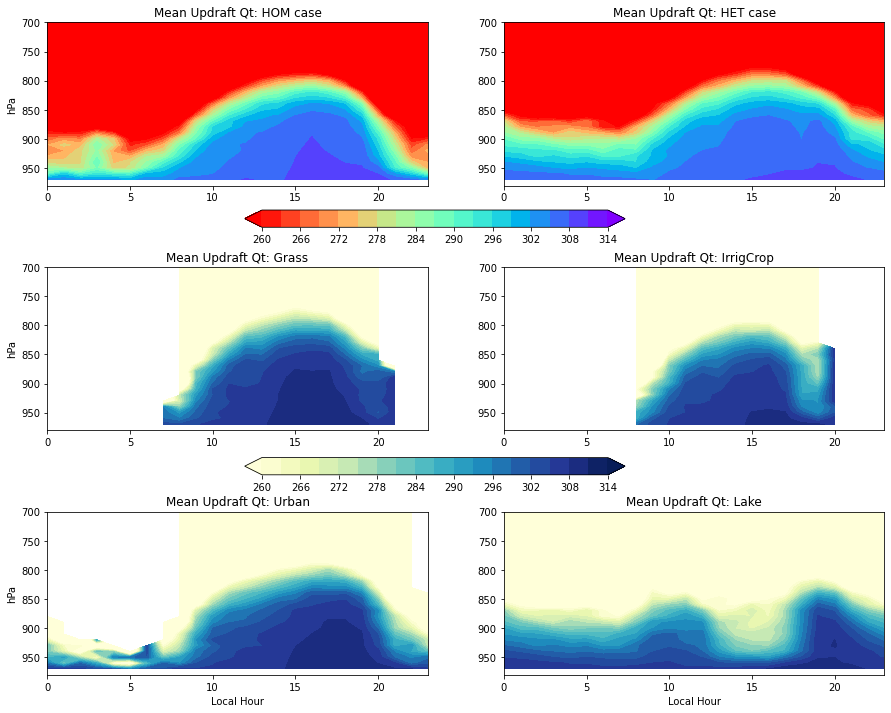

In [39]:
# ## Look at diurnal cycle of plume properties?
# varToPlot =  'thlu_macmicAvg_interp'

# # Look at diurnal cycle of plume initiations?
# nplumes_grassMean  = grassDS[varToPlot].weighted(grassDS.upa_macmicAvg_interp.fillna(0)).mean(dim='nens').resample(time='1H').mean().groupby('time.hour').mean(dim='time')
# nplumes_cropMean   = cropDS[varToPlot].weighted(cropDS.upa_macmicAvg_interp.fillna(0)).mean(dim='nens').resample(time='1H').mean().groupby('time.hour').mean(dim='time')
# nplumes_urbanMean  = urbanDS[varToPlot].weighted(urbanDS.upa_macmicAvg_interp.fillna(0)).mean(dim='nens').resample(time='1H').mean().groupby('time.hour').mean(dim='time')
# nplumes_lakeMean   = lakeDS[varToPlot].weighted(lakeDS.upa_macmicAvg_interp.fillna(0)).mean(dim='nens').resample(time='1H').mean().groupby('time.hour').mean(dim='time')

# HOMwgts = scamDS_h2.upa_macmicAvg_interp.sel(case='clubbMF_L0eq250').fillna(0)
# HETwgts = scamDS_h2.upa_macmicAvg_interp.sel(case='claspMF_L0eq250').fillna(0)
# nplumes_HOMmean    = scamDS_h2[varToPlot].sel(case='clubbMF_L0eq250').weighted(HOMwgts).mean(dim='nens').resample(time='1H').mean().groupby('time.hour').mean(dim='time')
# nplumes_HETmean    = scamDS_h2[varToPlot].sel(case='claspMF_L0eq250').weighted(HETwgts).mean(dim='nens').resample(time='1H').mean().groupby('time.hour').mean(dim='time')


# ## ----- Plot that ----- 
# fig,axs = plt.subplots(3,2, figsize=(15,12))
# axs = axs.ravel()

# ## Plot overall means 
# axs[0].contourf(nplumes_HOMmean.hour.values, nplumes_HOMmean.levInterp.values, 
#                 nplumes_HOMmean.values.transpose(), np.arange(260,315,3), 
#                 cmap = 'rainbow_r', extend='both')
# axs[0].set_title('Mean Updraft Qt: HOM case')

# cplot = axs[1].contourf(nplumes_HETmean.hour.values, nplumes_HETmean.levInterp.values, 
#                 nplumes_HETmean.values.transpose(), np.arange(260,315,3), 
#                 cmap = 'rainbow_r', extend='both')
# axs[1].set_title('Mean Updraft Qt: HET case')

# # add colorbar for overall mean cases 
# ax_position = axs[1].get_position()
# cbar_ax = fig.add_axes([ax_position.x0-0.24, ax_position.y0-0.015, ax_position.width, 0.02])
# cbar = plt.colorbar(cplot, orientation='horizontal',cax=cbar_ax)


# ## Plot patch data 
# axs[2].contourf(nplumes_grassMean.hour.values, nplumes_grassMean.levInterp.values, 
#                 nplumes_grassMean.values.transpose(), np.arange(260,315,3), 
#                 cmap = 'YlGnBu', extend='both')
# axs[2].set_title('Mean Updraft Qt: Grass')

# cplot=axs[3].contourf(nplumes_cropMean.hour.values, nplumes_cropMean.levInterp.values, 
#                 nplumes_cropMean.values.transpose(), np.arange(260,315,3), 
#                 cmap = 'YlGnBu', extend='both')
# axs[3].set_title('Mean Updraft Qt: IrrigCrop')
# # add colorbar for individual patches 
# ax_position = axs[3].get_position()
# cbar_ax = fig.add_axes([ax_position.x0-0.24, ax_position.y0-0.035, ax_position.width, 0.02])
# cbar = plt.colorbar(cplot, orientation='horizontal',cax=cbar_ax)

# axs[4].contourf(nplumes_urbanMean.hour.values, nplumes_urbanMean.levInterp.values, 
#                 nplumes_urbanMean.values.transpose(), np.arange(260,315,3), 
#                 cmap = 'YlGnBu', extend='both')
# axs[4].set_title('Mean Updraft Qt: Urban')

# cplot = axs[5].contourf(nplumes_lakeMean.hour.values, nplumes_lakeMean.levInterp.values, 
#                 nplumes_lakeMean.values.transpose(), np.arange(260,315,3), 
#                 cmap = 'YlGnBu', extend='both')
# axs[5].set_title('Mean Updraft Qt: Lake')


# ## Other plot options 
# axs[0].invert_yaxis()
# axs[1].invert_yaxis()
# axs[2].invert_yaxis()
# axs[3].invert_yaxis()
# axs[4].invert_yaxis()
# axs[5].invert_yaxis()

# axs[0].set_ylim([980,700])
# axs[1].set_ylim([980,700])
# axs[2].set_ylim([980,700])
# axs[3].set_ylim([980,700])
# axs[4].set_ylim([980,700])
# axs[5].set_ylim([980,700])

# # axs[0].set_xlim([7,19])
# # axs[1].set_xlim([7,19])
# # axs[2].set_xlim([7,19])
# # axs[3].set_xlim([7,19])
# # axs[4].set_xlim([7,19])
# # axs[5].set_xlim([7,19])

# axs[4].set_xlabel('Local Hour')
# axs[5].set_xlabel('Local Hour')

# axs[0].set_ylabel('hPa')
# axs[2].set_ylabel('hPa')
# axs[4].set_ylabel('hPa')

# fig.subplots_adjust(hspace = 0.5)


In [41]:
np.nanmin(grassDS.edmf_upbuoy_interp)


-0.20763326714830155

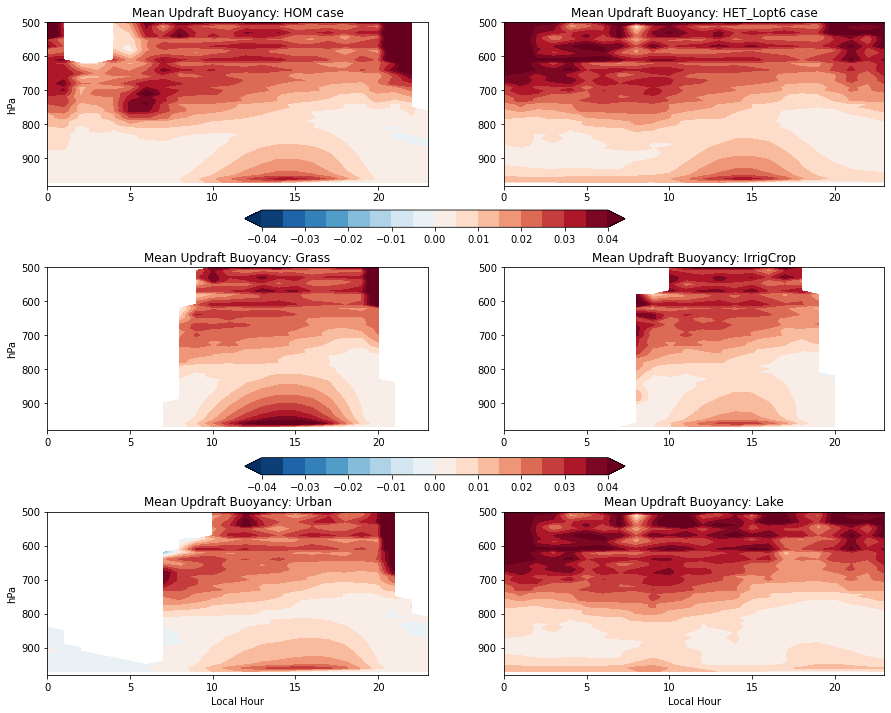

In [30]:
# varToPlot = 'edmf_upw_interp'
varToPlot = 'edmf_upbuoy_interp'

# Look at diurnal cycle of plume initiations?
nplumes_grassMean  = grassDS[varToPlot].sel(case='claspMF_Lopt6').weighted(grassDS.sel(case='claspMF_Lopt6').upa_macmicAvg_interp.fillna(0)).mean(dim='nens').resample(time='1H').mean().groupby('time.hour').mean(dim='time')
nplumes_cropMean   = cropDS[varToPlot].sel(case='claspMF_Lopt6').weighted(cropDS.sel(case='claspMF_Lopt6').upa_macmicAvg_interp.fillna(0)).mean(dim='nens').resample(time='1H').mean().groupby('time.hour').mean(dim='time')
nplumes_urbanMean  = urbanDS[varToPlot].sel(case='claspMF_Lopt6').weighted(urbanDS.sel(case='claspMF_Lopt6').upa_macmicAvg_interp.fillna(0)).mean(dim='nens').resample(time='1H').mean().groupby('time.hour').mean(dim='time')
nplumes_lakeMean   = lakeDS[varToPlot].sel(case='claspMF_Lopt6').weighted(lakeDS.sel(case='claspMF_Lopt6').upa_macmicAvg_interp.fillna(0)).mean(dim='nens').resample(time='1H').mean().groupby('time.hour').mean(dim='time')

HOMwgts = scamDS_h2.upa_macmicAvg_interp.sel(case='clubbMF_Lopt6').fillna(0)
HETwgts = scamDS_h2.upa_macmicAvg_interp.sel(case='claspMF_Lopt6').fillna(0)
nplumes_HOMmean    = scamDS_h2[varToPlot].sel(case='clubbMF_Lopt6').weighted(HOMwgts).mean(dim='nens').resample(time='1H').mean().groupby('time.hour').mean(dim='time')
nplumes_HETmean    = scamDS_h2[varToPlot].sel(case='claspMF_Lopt6').weighted(HETwgts).mean(dim='nens').resample(time='1H').mean().groupby('time.hour').mean(dim='time')


## ----- Plot that ----- 
fig,axs = plt.subplots(3,2, figsize=(15,12))
axs = axs.ravel()

## Plot overall means 
axs[0].contourf(nplumes_HOMmean.hour.values, nplumes_HOMmean.levInterp.values, 
                nplumes_HOMmean.values.transpose(), np.arange(-0.04,0.045,0.005), 
                cmap = 'RdBu_r', extend='both')
axs[0].set_title('Mean Updraft Buoyancy: HOM case')

cplot = axs[1].contourf(nplumes_HETmean.hour.values, nplumes_HETmean.levInterp.values, 
                nplumes_HETmean.values.transpose(), np.arange(-0.04,0.045,0.005), 
                cmap = 'RdBu_r', extend='both')
axs[1].set_title('Mean Updraft Buoyancy: HET_Lopt6 case')

# add colorbar for overall mean cases 
ax_position = axs[1].get_position()
cbar_ax = fig.add_axes([ax_position.x0-0.24, ax_position.y0-0.015, ax_position.width, 0.02])
cbar = plt.colorbar(cplot, orientation='horizontal',cax=cbar_ax)


## Plot patch data 
axs[2].contourf(nplumes_grassMean.hour.values, nplumes_grassMean.levInterp.values, 
                nplumes_grassMean.values.transpose(), np.arange(-0.04,0.045,0.005), 
                cmap = 'RdBu_r', extend='both')
axs[2].set_title('Mean Updraft Buoyancy: Grass')

cplot=axs[3].contourf(nplumes_cropMean.hour.values, nplumes_cropMean.levInterp.values, 
                nplumes_cropMean.values.transpose(), np.arange(-0.04,0.045,0.005), 
                cmap = 'RdBu_r', extend='both')
axs[3].set_title('Mean Updraft Buoyancy: IrrigCrop')
# add colorbar for individual patches 
ax_position = axs[3].get_position()
cbar_ax = fig.add_axes([ax_position.x0-0.24, ax_position.y0-0.035, ax_position.width, 0.02])
cbar = plt.colorbar(cplot, orientation='horizontal',cax=cbar_ax)

axs[4].contourf(nplumes_urbanMean.hour.values, nplumes_urbanMean.levInterp.values, 
                nplumes_urbanMean.values.transpose(), np.arange(-0.04,0.045,0.005), 
                cmap = 'RdBu_r', extend='both')
axs[4].set_title('Mean Updraft Buoyancy: Urban')

cplot = axs[5].contourf(nplumes_lakeMean.hour.values, nplumes_lakeMean.levInterp.values, 
                nplumes_lakeMean.values.transpose(), np.arange(-0.04,0.045,0.005), 
                cmap = 'RdBu_r', extend='both')
axs[5].set_title('Mean Updraft Buoyancy: Lake')


## Other plot options 
axs[0].invert_yaxis()
axs[1].invert_yaxis()
axs[2].invert_yaxis()
axs[3].invert_yaxis()
axs[4].invert_yaxis()
axs[5].invert_yaxis()

axs[0].set_ylim([980,500])
axs[1].set_ylim([980,500])
axs[2].set_ylim([980,500])
axs[3].set_ylim([980,500])
axs[4].set_ylim([980,500])
axs[5].set_ylim([980,500])

# axs[0].set_xlim([7,19])
# axs[1].set_xlim([7,19])
# axs[2].set_xlim([7,19])
# axs[3].set_xlim([7,19])
# axs[4].set_xlim([7,19])
# axs[5].set_xlim([7,19])

axs[4].set_xlabel('Local Hour')
axs[5].set_xlabel('Local Hour')

axs[0].set_ylabel('hPa')
axs[2].set_ylabel('hPa')
axs[4].set_ylabel('hPa')

# axs[0].axhline(850, color='k')
# axs[1].axhline(850, color='k')


fig.subplots_adjust(hspace = 0.5)


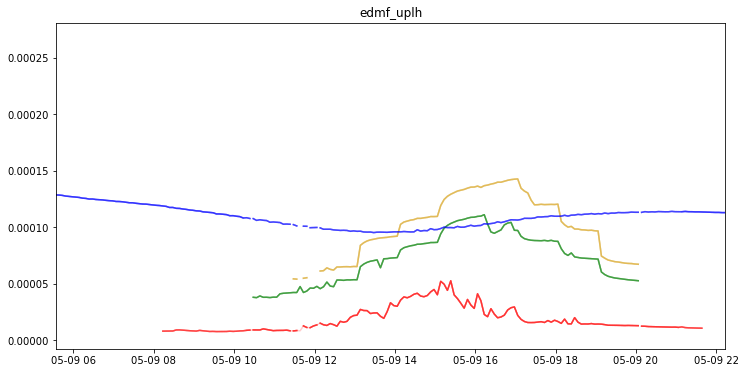

In [22]:
fig,axs = plt.subplots(1,1,figsize=(12,6))


for iEns in range(25):
    plt.plot(urbanDS.time.values, urbanDS.isel(ilev=-1, nens=iEns).edmf_uplh.values,'r', alpha=0.2)
    plt.plot(lakeDS.time.values, lakeDS.isel(ilev=-1, nens=iEns).edmf_uplh.values,'b', alpha=0.2)
    plt.plot(grassDS.time.values, grassDS.isel(ilev=-1, nens=iEns).edmf_uplh.values,'g', alpha=0.2)
    plt.plot(cropDS.time.values, cropDS.isel(ilev=-1, nens=iEns).edmf_uplh.values,color='goldenrod', alpha=0.2)
    
    
    plt.title('edmf_uplh')
    plt.xlim([urbanDS.time.values[5250], urbanDS.time.values[5450]])


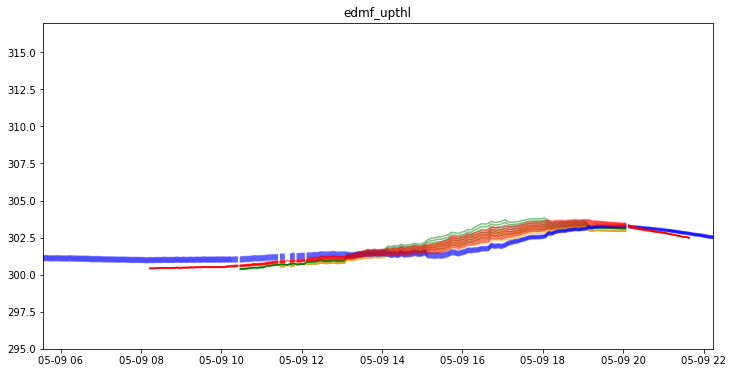

In [23]:
fig,axs = plt.subplots(1,1,figsize=(12,6))

for iEns in range(25):
    plt.plot(urbanDS.time.values, urbanDS.isel(ilev=-1, nens=iEns).edmf_upthl.values,'r', alpha=0.5)
    plt.plot(lakeDS.time.values, lakeDS.isel(ilev=-1, nens=iEns).edmf_upthl.values,'b', alpha=0.5)
    plt.plot(grassDS.time.values, grassDS.isel(ilev=-1, nens=iEns).edmf_upthl.values,'g', alpha=0.5)
    plt.plot(cropDS.time.values, cropDS.isel(ilev=-1, nens=iEns).edmf_upthl.values,color='goldenrod', alpha=0.5)
    
    
    plt.title('edmf_upthl')
    plt.ylim([295,317])
    plt.xlim([urbanDS.time.values[5250], urbanDS.time.values[5450]])


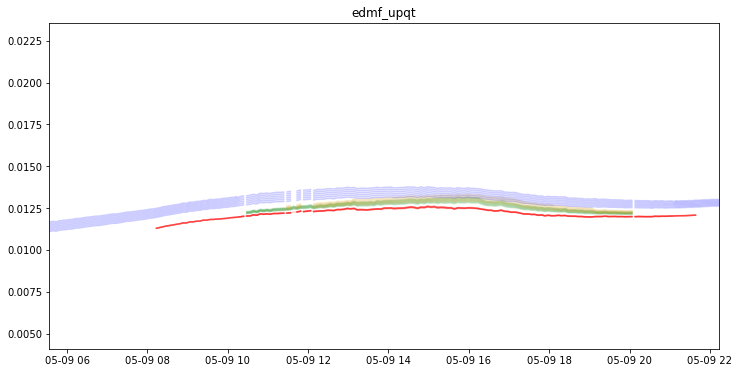

In [24]:
fig,axs = plt.subplots(1,1,figsize=(12,6))

for iEns in range(25):
    plt.plot(urbanDS.time.values, urbanDS.isel(ilev=-1, nens=iEns).edmf_upqt.values,'r', alpha=0.2)
    plt.plot(lakeDS.time.values, lakeDS.isel(ilev=-1, nens=iEns).edmf_upqt.values,'b', alpha=0.2)
    plt.plot(grassDS.time.values, grassDS.isel(ilev=-1, nens=iEns).edmf_upqt.values,'g', alpha=0.2)
    plt.plot(cropDS.time.values, cropDS.isel(ilev=-1, nens=iEns).edmf_upqt.values,color='goldenrod', alpha=0.2)
    
    
    plt.title('edmf_upqt')
    plt.xlim([urbanDS.time.values[5250], urbanDS.time.values[5450]])


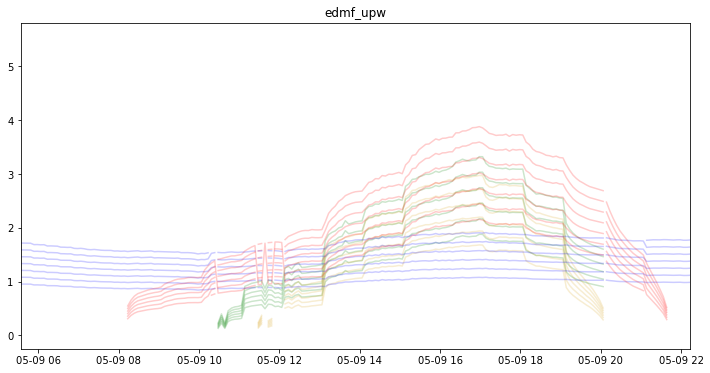

In [25]:
fig,axs = plt.subplots(1,1,figsize=(12,6))


for iEns in range(25):
    plt.plot(urbanDS.time.values, urbanDS.isel(ilev=-1, nens=iEns).edmf_upw.values,'r', alpha=0.2)
    plt.plot(lakeDS.time.values, lakeDS.isel(ilev=-1, nens=iEns).edmf_upw.values,'b', alpha=0.2)
    plt.plot(grassDS.time.values, grassDS.isel(ilev=-1, nens=iEns).edmf_upw.values,'g', alpha=0.2)
    plt.plot(cropDS.time.values, cropDS.isel(ilev=-1, nens=iEns).edmf_upw.values,color='goldenrod', alpha=0.2)
    
    
    plt.title('edmf_upw')
    plt.xlim([urbanDS.time.values[5250], urbanDS.time.values[5450]])


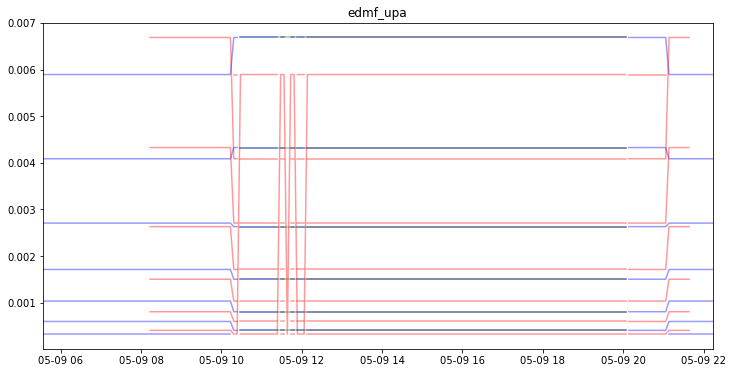

In [26]:
fig,axs = plt.subplots(1,1,figsize=(12,6))


for iEns in range(25):
    plt.plot(urbanDS.time.values, urbanDS.isel(ilev=-1, nens=iEns).edmf_upa.values,'r', alpha=0.4)
    plt.plot(lakeDS.time.values, lakeDS.isel(ilev=-1, nens=iEns).edmf_upa.values,'b', alpha=0.4)
    plt.plot(grassDS.time.values, grassDS.isel(ilev=-1, nens=iEns).edmf_upa.values,'g', alpha=0.4)
    plt.plot(cropDS.time.values, cropDS.isel(ilev=-1, nens=iEns).edmf_upa.values,color='goldenrod', alpha=0.4)
    
    
    plt.title('edmf_upa')
    plt.xlim([urbanDS.time.values[5250], urbanDS.time.values[5450]])


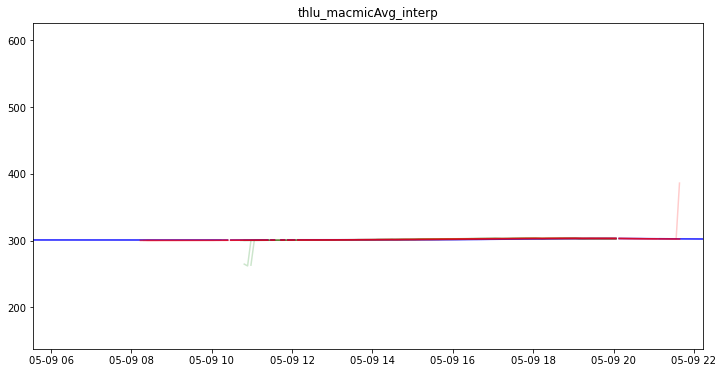

In [27]:
fig,axs = plt.subplots(1,1,figsize=(12,6))


for iEns in range(25):
    plt.plot(urbanDS.time.values, urbanDS.isel(levInterp=-1, nens=iEns).thlu_macmicAvg_interp.values,'r', alpha=0.2)
    plt.plot(lakeDS.time.values, lakeDS.isel(levInterp=-1, nens=iEns).thlu_macmicAvg_interp.values,'b', alpha=0.2)
    plt.plot(grassDS.time.values, grassDS.isel(levInterp=-1, nens=iEns).thlu_macmicAvg_interp.values,'g', alpha=0.2)
    plt.plot(cropDS.time.values, cropDS.isel(levInterp=-1, nens=iEns).thlu_macmicAvg_interp.values,color='goldenrod', alpha=0.2)
    
    
    plt.title('thlu_macmicAvg_interp')
    plt.xlim([urbanDS.time.values[5250], urbanDS.time.values[5450]])


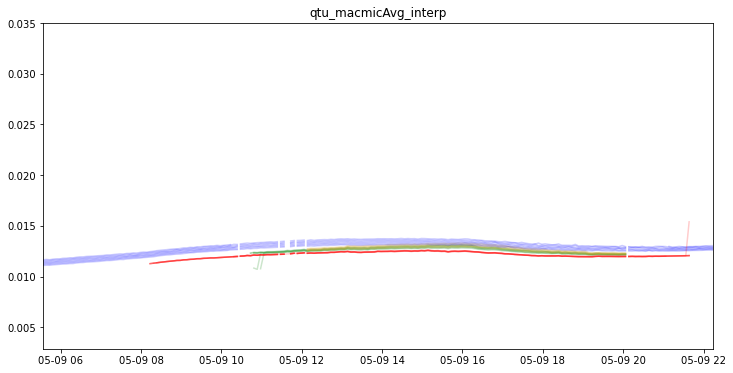

In [28]:
fig,axs = plt.subplots(1,1,figsize=(12,6))


for iEns in range(25):
    plt.plot(urbanDS.time.values, urbanDS.isel(levInterp=-1, nens=iEns).qtu_macmicAvg_interp.values,'r', alpha=0.2)
    plt.plot(lakeDS.time.values, lakeDS.isel(levInterp=-1, nens=iEns).qtu_macmicAvg_interp.values,'b', alpha=0.2)
    plt.plot(grassDS.time.values, grassDS.isel(levInterp=-1, nens=iEns).qtu_macmicAvg_interp.values,'g', alpha=0.2)
    plt.plot(cropDS.time.values, cropDS.isel(levInterp=-1, nens=iEns).qtu_macmicAvg_interp.values,color='goldenrod', alpha=0.2)
    
    
    plt.title('qtu_macmicAvg_interp')
    plt.xlim([urbanDS.time.values[5250], urbanDS.time.values[5450]])


### Diurnal cycle plots?

In [10]:
## Get hourly mean SCAM 
hourlyMeanSCAM  = scamDS.groupby('time.hour').mean(dim='time')
hourlyStdSCAM   = scamDS.groupby('time.hour').std(dim='time')
hourlyCountSCAM = scamDS.groupby('time.hour').count(dim='time')
hourlySE = hourlyStdSCAM/np.sqrt(hourlyCountSCAM)

hourlyMeanSCAM_h2  = scamDS_h2.groupby('time.hour').mean(dim='time')

# hourlyMeanCLM_h0 = clmDS_h0.groupby('time.hour').mean(dim='time')
hourlyMeanCLM_h1 = clmDS_h1.groupby('time.hour').mean(dim='time')
hourlyMeanCLM_h2 = clmDS_h2.groupby('time.hour').mean(dim='time')



In [11]:
CIlevel = 1.960   ## 95% CI 

TypeError: invalid indexer array, does not have integer dtype: array('clubbMF_Lopt6', dtype='<U13')

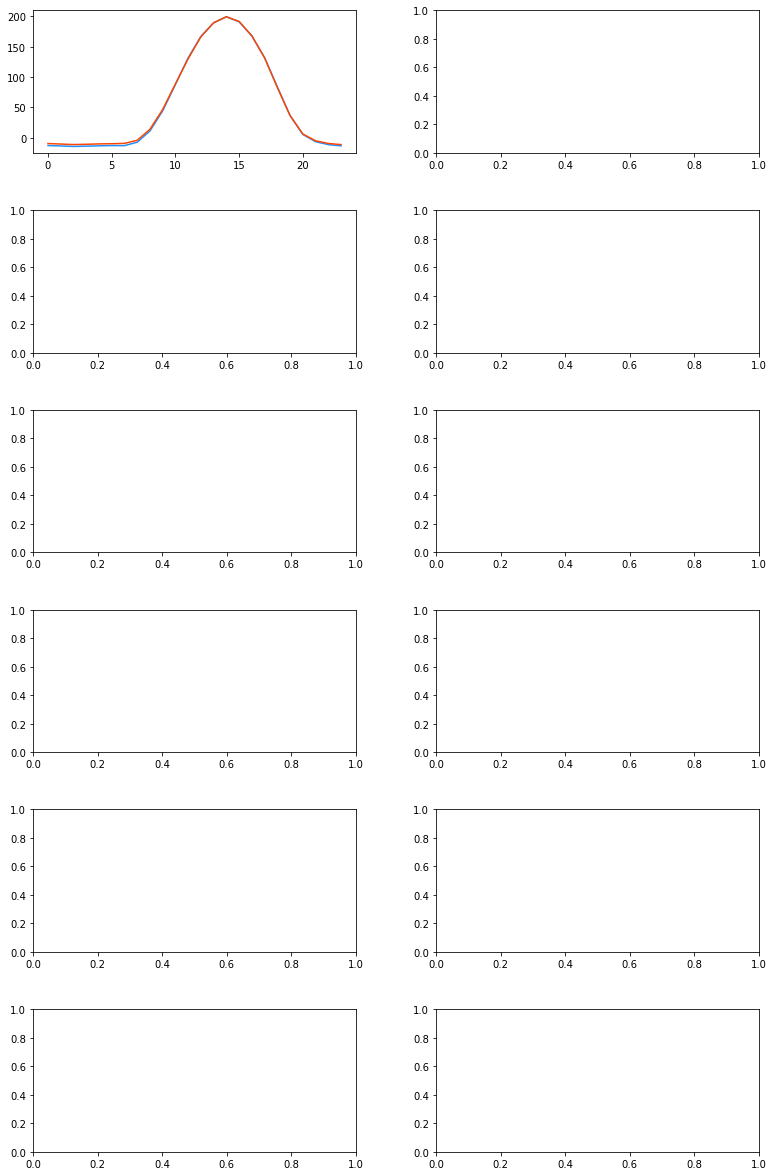

In [12]:
pltVars = ['SHFLX','LHFLX',
           'TREFHT','QREFHT',
           'SWCF','LWCF',
           'CLDTOT','PRECC',
           'TGCLDLWP','PBLH',
           'CLDLOW','TMQ']

ctrlCase = 'clubbMF_Lopt6'
# testCase = 'claspMF_L0eq50'
testCase = 'claspMF_Lopt6'
# testCase = 'claspMF_L0eq250_rand'

fig, axs = plt.subplots(int(len(pltVars)/2), 2, figsize=(13,3.5*len(pltVars)/2) )
axs      = axs.ravel()
fig.subplots_adjust(wspace=0.25, hspace=0.4)

for iPlt in range(len(pltVars)):

    if pltVars[iPlt]=='PRECC': 
        axs[iPlt].plot(hourlyMeanSCAM.hour.values, np.squeeze(hourlyMeanSCAM[pltVars[iPlt]].sel(case=ctrlCase).values)*(3600*1e3), 
                 color='dodgerblue', label=ctrlCase)
        axs[iPlt].plot(hourlyMeanSCAM.hour.values, np.squeeze(hourlyMeanSCAM[pltVars[iPlt]].sel(case=testCase).values)*(3600*1e3), 
                 color='orangered', label=testCase)   
    else: 
        axs[iPlt].plot(hourlyMeanSCAM.hour.values, np.squeeze(hourlyMeanSCAM[pltVars[iPlt]].sel(case=ctrlCase).values), 
             color='dodgerblue', label=ctrlCase)
        axs[iPlt].plot(hourlyMeanSCAM.hour.values, np.squeeze(hourlyMeanSCAM[pltVars[iPlt]].sel(case=testCase).values), 
                 color='orangered', label=testCase)
        
        ## Add some error bars? 
        axs[iPlt].fill_between(hourlyMeanSCAM.hour.values, 
           np.squeeze(hourlyMeanSCAM[pltVars[iPlt]].sel(case=ctrlCase).values)-(CIlevel*np.squeeze(hourlySE.isel(case=ctrlCase)[pltVars[iPlt]].values)),
           np.squeeze(hourlyMeanSCAM[pltVars[iPlt]].sel(case=ctrlCase).values)+(CIlevel*np.squeeze(hourlySE.isel(case=ctrlCase)[pltVars[iPlt]].values)),
           alpha = 0.2, facecolor='dodgerblue')
        
        axs[iPlt].fill_between(hourlyMeanSCAM.hour.values, 
           np.squeeze(hourlyMeanSCAM[pltVars[iPlt]].sel(case=testCase).values)-(CIlevel*np.squeeze(hourlySE.isel(case=testCase)[pltVars[iPlt]].values)),
           np.squeeze(hourlyMeanSCAM[pltVars[iPlt]].sel(case=testCase).values)+(CIlevel*np.squeeze(hourlySE.isel(case=testCase)[pltVars[iPlt]].values)),
           alpha = 0.2, facecolor='orangered')
    

    axs[iPlt].legend(fontsize=12,)

    # axs.set_ylabel('K kg/kg')
    axs[iPlt].set_xlabel('Hour')
    axs[iPlt].set_title(pltVars[iPlt], fontsize=14)


Text(0.5, 1.0, 'TG')

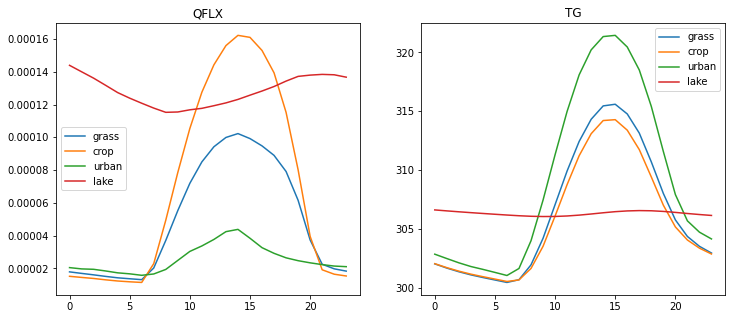

In [33]:
fig,axs = plt.subplots(1,2, figsize=(12,5))
axs= axs.ravel()

for iLU in range(4):
    axs[0].plot(hourlyMeanCLM_h2.sel(case='claspMF_Lopt6').hour.values, hourlyMeanCLM_h2.sel(case='claspMF_Lopt6').sel(landunit=iLU).QFLX.values)
    axs[1].plot(hourlyMeanCLM_h2.sel(case='claspMF_Lopt6').hour.values, hourlyMeanCLM_h2.sel(case='claspMF_Lopt6').sel(landunit=iLU).TG.values)

axs[0].legend(['grass','crop','urban','lake'])   
axs[1].legend(['grass','crop','urban','lake'])   

axs[0].set_title('QFLX')
axs[1].set_title('TG')


In [10]:
hourlyMeanSCAM_h2  = scamDS_h2.groupby('time.hour').mean(dim='time')


Text(0, 0.5, 'm')

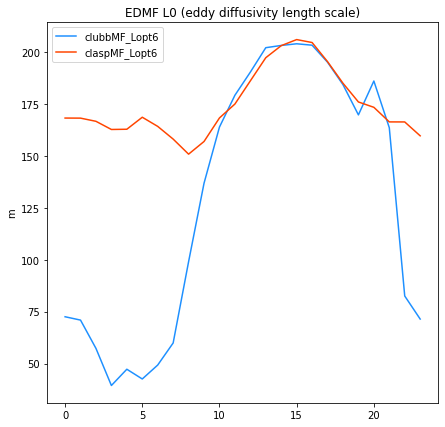

In [12]:
fig,axs = plt.subplots(1,1,figsize=(7,7)) 

ctrlCase = 'clubbMF_Lopt6'
testCase = 'claspMF_Lopt6'

axs.plot(hourlyMeanSCAM_h2.hour.values, hourlyMeanSCAM_h2.edmf_L0.sel(case=ctrlCase).values, color='dodgerblue', label=ctrlCase)
axs.plot(hourlyMeanSCAM_h2.hour.values, hourlyMeanSCAM_h2.edmf_L0.sel(case=testCase).values, color='orangered', label=testCase)

axs.legend()
axs.set_title('EDMF L0 (eddy diffusivity length scale)')
axs.set_ylabel('m')


### Time-height plots

In [34]:
## Get hourly mean SCAM 
hourlyMeanSCAM  = scamDS.groupby('time.hour').mean(dim='time')
hourlyStdSCAM   = scamDS.groupby('time.hour').std(dim='time')
hourlyCountSCAM = scamDS.groupby('time.hour').count(dim='time')
hourlySE = hourlyStdSCAM/np.sqrt(hourlyCountSCAM)

hourlyMeanSCAM_h2  = scamDS_h2.groupby('time.hour').mean(dim='time')
hourlyStdSCAM_h2   = scamDS_h2.groupby('time.hour').std(dim='time')
hourlyCountSCAM_h2 = scamDS_h2.groupby('time.hour').count(dim='time')
hourlySE_h2 = hourlyStdSCAM_h2/np.sqrt(hourlyCountSCAM_h2)


In [35]:
## Add significance testing 
CIlevel = 1.960   ## 95% CI
# CIlevel = 1.645   ## 90% CI

CI = CIlevel*hourlySE
lowCI = hourlyMeanSCAM - CI
hghCI = hourlyMeanSCAM + CI

# CI_h2 = CIlevel*hourlySE_h2
# lowCI_h2 = hourlyMeanSCAM_h2 - CI_h2
# hghCI_h2 = hourlyMeanSCAM_h2 + CI_h2


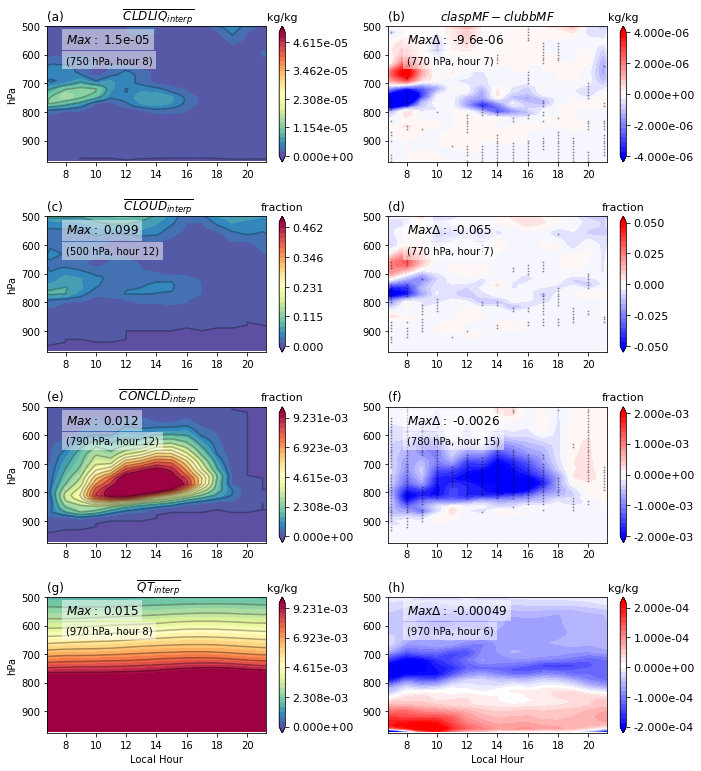

In [36]:
# Set up figure
pltVars  = ['CLDLIQ_interp', 
            'CLOUD_interp',
            'CONCLD_interp',
            'QT_interp',
           ]

cMin    = [0.0, 
           0.0,
           0.0,
           0.0,
          ]

cMax    = [0.5e-4,
           0.5,
           0.01,
           0.1e-1,
          ]

diffMax = [0.4e-5,
           0.05,
           0.2e-2, 
           0.2e-3, 
          ]

multpl = [
          1,
          1,
          1,
          1, 
         ]

maxLev  = 500

units = [
         r'kg/kg',
         r'fraction',
         r'fraction',
         r'kg/kg', 
        ]

cfmt_hmg = ['%.3e', '%.3f','%.3e','%.3e'] # colorbar label formater
cfmt_htg = ['%.3e', '%.3f','%.3e','%.3e'] # colorbar label formater


subPltLabel = [['(a)','(b)'],
               ['(c)','(d)'],
               ['(e)','(f)'],
               ['(g)','(h)'],
               ['(i)','(j)'],
               ['(k)','(l)']]

varLabel    = [
               r" $\overline{CLDLIQ_{interp}}$",
               r" $\overline{CLOUD_{interp}}$",
               r" $\overline{CONCLD_{interp}}$",
               r" $\overline{QT_{interp}}$",
              ]


fig, axs = plt.subplots(len(pltVars), 2, figsize=(11,3.25*len(pltVars)) )
axs      = axs.ravel()
fig.subplots_adjust(wspace=0.25, hspace=0.4)

# Set up case 
ctrlCase = 'clubbMF_Lopt6'
# testCase = 'claspMF_L0eq50'
testCase = 'claspMF_Lopt6'
# testCase = 'claspMF_L0eq250_rand'


for iVar in range(len(pltVars)): 
    
    if pltVars[iVar]=='edmf_cloudfrac_interp':
        ctrlDS    = hourlyMeanSCAM_h2.sel(case=ctrlCase)
        testDS    = hourlyMeanSCAM_h2.sel(case=testCase)
        diffCases = testDS - ctrlDS        
    else:
        ctrlDS    = hourlyMeanSCAM.sel(case=ctrlCase)
        testDS    = hourlyMeanSCAM.sel(case=testCase)
        diffCases = testDS - ctrlDS
    
# for iVar in range(2): 
    # - - - - Plot control case - - - -
    cplt = axs[iVar*2].contourf(ctrlDS.hour.values, ctrlDS.levInterp.values, 
                       np.squeeze(ctrlDS[pltVars[iVar]].values * multpl[iVar]).transpose(),
                       np.arange(cMin[iVar], cMax[iVar], (cMax[iVar]-cMin[iVar])/26), 
                       cmap='Spectral_r', extend='both')
    # Add colorbar
    if (pltVars[iVar]=='RTPTHLP_CLUBB_interp'):
            cbar = fig.colorbar(cplt, ax=axs[(iVar*2)], format=cfmt_hmg[iVar],
                                ticks=[cMin[iVar], cMin[iVar]/2, 0, cMax[iVar]/2, cMax[iVar]])
    else: 
        cbar = fig.colorbar(cplt, ax=axs[(iVar*2)], format=cfmt_hmg[iVar])
        cbar.ax.locator_params(nbins=6)
    cbar.ax.set_title(units[iVar], fontsize=11)
    cbar.ax.tick_params(labelsize=11) 
    
    
    # Add contour lines
    cplt = axs[iVar*2].contour(ctrlDS.hour.values, ctrlDS.levInterp.values, 
                    np.squeeze(ctrlDS[pltVars[iVar]].values * multpl[iVar]).transpose(),
                    np.arange(cMin[iVar], cMax[iVar], (cMax[iVar]-cMin[iVar])/26)[::2], colors='k', alpha=0.3 )
    
    ## Add inset text for max/min
    varVal,varHgt,varTime = getMaxValHeightTime(ctrlDS, pltVars[iVar], maxLev, 'levInterp','hour')

    axs[iVar*2].text(8,560,r'$Max:$ %.2g' % (varVal * multpl[iVar]), 
                fontfamily='sans-serif', fontsize='large').set_bbox(dict(facecolor='white', edgecolor='none', alpha=0.5))
    axs[iVar*2].text(8,630,'(%i hPa, hour %i)' % (varHgt,varTime), 
                fontfamily='sans-serif', fontsize='medium').set_bbox(dict(facecolor='white', edgecolor='none', alpha=0.5))

    
    # - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
    # - - - - Plot difference case - - - -
    nStep = (2*diffMax[iVar])/26
    
    cplt = axs[(iVar*2)+1].contourf(diffCases.hour.values, diffCases.levInterp.values, 
                    np.squeeze(diffCases[pltVars[iVar]].values* multpl[iVar]).transpose(),
                    np.arange(-diffMax[iVar], diffMax[iVar]+nStep, nStep), cmap='bwr', extend='both')

    cbar = fig.colorbar(cplt, ax=axs[(iVar*2)+1], format=cfmt_htg[iVar],
                        ticks=[-diffMax[iVar], -diffMax[iVar]/2, 0, diffMax[iVar]/2, diffMax[iVar]])
    cbar.ax.locator_params(nbins=6)
    cbar.ax.set_title(units[iVar], fontsize=11)
    cbar.ax.tick_params(labelsize=11)  
    
    ## Add inset text for max difference 
    diffVal,diffHgt,diffTime = getMaxValHeightTime(diffCases, pltVars[iVar], maxLev, 'levInterp','hour')
    
    axs[(iVar*2)+1].text(8,560,r'$Max  \Delta:$ %.2g' % (diffVal* multpl[iVar]), 
                fontfamily='sans-serif', fontsize='large').set_bbox(dict(facecolor='white', edgecolor='none', alpha=0.5))
    axs[(iVar*2)+1].text(8,630,'(%i hPa, hour %i)' % (diffHgt,diffTime), 
                fontfamily='sans-serif', fontsize='medium').set_bbox(dict(facecolor='white', edgecolor='none', alpha=0.5))

    ## Add significance testing 
    levSig    = getStatSigCI(len(diffCases.hour.values), 
                                   len(diffCases.levInterp.values), pltVars[iVar],   ctrlCase, testCase)  

    for iHr in range(len(diffCases.hour.values)): 
        for iLev in range(len(diffCases.levInterp.values)): 
            if levSig[iHr, iLev]==1: 
                axs[(iVar*2)+1].plot(diffCases.hour.values[iHr], diffCases.levInterp.values[iLev],
                            'ko',alpha=0.3,markersize=1)

    
    # - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
    # - - - - Other plot options - - - -
    axs[iVar*2].invert_yaxis()
    axs[(iVar*2)+1].invert_yaxis()

    axs[(iVar*2)].set_ylim([975, maxLev])
    axs[(iVar*2)+1].set_ylim([975, maxLev])

    axs[(iVar*2)].set_title(subPltLabel[iVar][0], loc='left')
    axs[(iVar*2)].set_title(varLabel[iVar])
    
    if iVar==0:
        axs[(iVar*2)+1].set_title(subPltLabel[iVar][1], loc='left')
        axs[(iVar*2)+1].set_title(r'$claspMF - clubbMF$')
    else: 
        axs[(iVar*2)+1].set_title(subPltLabel[iVar][1], loc='left')

    axs[(iVar*2)].set_ylabel('hPa')
    
    axs[(iVar*2)].set_xlim([6.8,21.2])
    axs[(iVar*2)+1].set_xlim([6.8,21.2])
    axs[(iVar*2)].set_xticks([8,10,12,14,16,18,20])
    axs[(iVar*2)+1].set_xticks([8,10,12,14,16,18,20])
    
    if iVar==len(pltVars)-1: 
        axs[(iVar*2)].set_xlabel('Local Hour')
        axs[(iVar*2)+1].set_xlabel('Local Hour')
        


In [37]:
def getStatSigCI_h2(nTimes, nLevs, varSel, ctrlCase, testCase, CIlevel): 

    ## Get ranges for each case's CI 
    CI_h2_ctrl           = CIlevel*hourlySE_h2.sel(case=ctrlCase)[varSel]
    CI_h2_test           = CIlevel*hourlySE_h2.sel(case=testCase)[varSel]

#     ctrlDS_lowCI    = np.nansum([hourlyMeanSCAM_h2.sel(case=ctrlCase).isel(lon=0,lat=0)[varSel], -CI_h2_ctrl], axis=0)
#     testDS_lowCI    = np.nansum([hourlyMeanSCAM_h2.sel(case=testCase).isel(lon=0,lat=0)[varSel], -CI_h2_test], axis=0)

#     ctrlDS_hghCI    = np.nansum([hourlyMeanSCAM_h2.sel(case=ctrlCase).isel(lon=0,lat=0)[varSel], CI_h2_ctrl], axis=0)
#     testDS_hghCI    = np.nansum([hourlyMeanSCAM_h2.sel(case=testCase).isel(lon=0,lat=0)[varSel], CI_h2_test], axis=0)

    ctrlDS_lowCI    = hourlyMeanSCAM_h2.sel(case=ctrlCase)[varSel] -CI_h2_ctrl
    testDS_lowCI    = hourlyMeanSCAM_h2.sel(case=testCase)[varSel] -CI_h2_test

    ctrlDS_hghCI    = hourlyMeanSCAM_h2.sel(case=ctrlCase)[varSel] + CI_h2_ctrl
    testDS_hghCI    = hourlyMeanSCAM_h2.sel(case=testCase)[varSel] + CI_h2_test



    levSig = np.full([nTimes, nLevs], np.nan)

    for iHr in range(nTimes): 
        for iLev in range(nLevs):

            # Not significant range?
            if ( (testDS_lowCI.values[iHr,iLev] >= ctrlDS_lowCI.values[iHr,iLev]) & (testDS_lowCI.values[iHr,iLev] <= ctrlDS_hghCI.values[iHr,iLev]) ): 
                levSig[iHr,iLev]  = 0 
            elif ( (testDS_hghCI.values[iHr,iLev] >= ctrlDS_lowCI.values[iHr,iLev]) & (testDS_hghCI.values[iHr,iLev] <= ctrlDS_hghCI.values[iHr,iLev]) ): 
                levSig[iHr,iLev]  = 0 
            
            elif ( (ctrlDS_lowCI.values[iHr,iLev] >= testDS_lowCI.values[iHr,iLev]) & (ctrlDS_lowCI.values[iHr,iLev] <= testDS_hghCI.values[iHr,iLev]) ): 
                levSig[iHr,iLev]  = 0 
            elif ( (ctrlDS_hghCI.values[iHr,iLev] >= testDS_lowCI.values[iHr,iLev]) & (ctrlDS_hghCI.values[iHr,iLev] <= testDS_hghCI.values[iHr,iLev]) ): 
                levSig[iHr,iLev]  = 0       
            
            elif np.isfinite(testDS_lowCI.values[iHr,iLev])==False:
                levSig[iHr,iLev]  = 0
            elif np.isfinite(ctrlDS_lowCI.values[iHr,iLev])==False:
                levSig[iHr,iLev]  = 0            
            elif np.isfinite(testDS_hghCI.values[iHr,iLev])==False:
                levSig[iHr,iLev]  = 0
            elif np.isfinite(ctrlDS_hghCI.values[iHr,iLev])==False:
                levSig[iHr,iLev]  = 0  
                
            else:
                levSig[iHr, iLev] = 1 
    
    return levSig

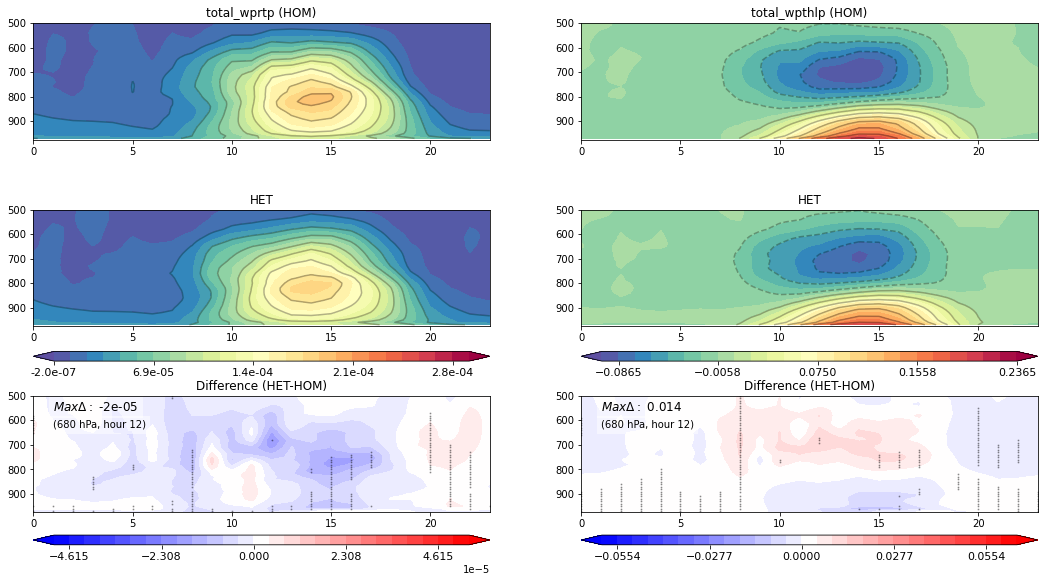

In [38]:
ctrlCase = 'clubbMF_Lopt6'
# testCase = 'claspMF_L0eq50'
testCase = 'claspMF_Lopt6'
# testCase = 'claspMF_L0eq250_rand'

pltVars  = [
            'total_wprtp',
            'total_wpthlp',
            # 'edmf_qtflxup_interp',
            # 'edmf_thlflxup_interp', 
            ]

cMin    = [
          -2e-7, 
           -0.1,
          ]

cMax    = [
           3e-4,
           0.25,
          ]

diffMax = [
           5.0e-5,
           0.06,
          ]

maxLev  = 500

units = [
         r'$kg/kg m$ $s^{-1}$',
         r'$K m$ $s^{-1}$',
        ]

fig,axs = plt.subplots(3, len(pltVars), figsize=(18,9))
axs     = axs.ravel()

ctrlDS    = hourlyMeanSCAM_h2.sel(case=ctrlCase)
testDS    = hourlyMeanSCAM_h2.sel(case=testCase)
diffCases = testDS - ctrlDS

for iVar in range(len(pltVars)): 

        # - - - - Plot control case - - - -
        cplt = axs[iVar].contourf(ctrlDS['hour'].values, ctrlDS.levInterp.values, 
                       np.squeeze(ctrlDS[pltVars[iVar]].values).transpose(),
                       np.arange(cMin[iVar], cMax[iVar], (cMax[iVar]-cMin[iVar])/26), 
                       cmap='Spectral_r', extend='both')

        # Add contour lines
        cplt = axs[iVar].contour(ctrlDS['hour'].values, ctrlDS.levInterp.values, 
                        np.squeeze(ctrlDS[pltVars[iVar]].values).transpose(),
                        np.arange(cMin[iVar], cMax[iVar], (cMax[iVar]-cMin[iVar])/26)[::2], colors='k', alpha=0.3 )

        axs[iVar].set_title(pltVars[iVar]+' (HOM)')


        # - - - - Plot CLASP case - - - -
        cplt = axs[iVar+len(pltVars)].contourf(testDS['hour'].values, testDS.levInterp.values, 
                       np.squeeze(testDS[pltVars[iVar]].values).transpose(),
                       np.arange(cMin[iVar], cMax[iVar], (cMax[iVar]-cMin[iVar])/26), 
                       cmap='Spectral_r', extend='both')
        ax_position = axs[iVar+len(pltVars)].get_position()
#             cbar_ax = fig.add_axes([ax_position.x0-0.1, ax_position.y0-0.038, ax_position.width+0.15, 0.015])
        if pltVars[iVar]=='total_wprtp':
            cbar_ax = fig.add_axes([ax_position.x0, ax_position.y0-0.033, ax_position.width, 0.015])
            cbar = fig.colorbar(cplt, cax=cbar_ax, orientation='horizontal', format='%.1e')
            cbar.ax.locator_params(nbins=7)
            # cbar.ax.set_title(units[iVar], fontsize=11)
            cbar.ax.tick_params(labelsize=11) 
        else:
            cbar_ax = fig.add_axes([ax_position.x0, ax_position.y0-0.033, ax_position.width, 0.015])
            cbar = fig.colorbar(cplt, cax=cbar_ax, orientation='horizontal')
            cbar.ax.locator_params(nbins=6)
            # cbar.ax.set_title(units[iVar], fontsize=11)
            cbar.ax.tick_params(labelsize=11) 

        # Add contour lines
        cplt = axs[iVar+len(pltVars)].contour(testDS['hour'].values, testDS.levInterp.values, 
                        np.squeeze(testDS[pltVars[iVar]].values).transpose(),
                        np.arange(cMin[iVar], cMax[iVar], (cMax[iVar]-cMin[iVar])/26)[::2], colors='k', alpha=0.3 )        

        axs[iVar+len(pltVars)].set_title('HET')
        

        # - - - - Plot DIFF case - - - -
        cplt = axs[iVar+(2*len(pltVars))].contourf(diffCases['hour'].values, diffCases.levInterp.values, 
                       np.squeeze(diffCases[pltVars[iVar]].values ).transpose(),
                       np.arange(-diffMax[iVar], diffMax[iVar]+((diffMax[iVar]*2)/26), (diffMax[iVar]*2)/26), 
                       cmap='bwr', extend='both')

        ax_position = axs[iVar+(2*len(pltVars))].get_position()
        cbar_ax = fig.add_axes([ax_position.x0, ax_position.y0-0.05, ax_position.width, 0.015])
        cbar = fig.colorbar(cplt, cax=cbar_ax, orientation='horizontal')
        cbar.ax.locator_params(nbins=6)
        # cbar.ax.set_title(units[iVar], fontsize=11)
        cbar.ax.tick_params(labelsize=11) 

#         # Add contour lines
#         cplt = axs[iVar+(2*len(pltVars))].contour(diffCases['hour'].values, diffCases.levInterp.values, 
#                         np.squeeze(diffCases[pltVars[iVar]].values ).transpose(),
#                         np.arange(-diffMax[iVar], diffMax[iVar]+((diffMax[iVar]*2)/26), (diffMax[iVar]*2)/26)[::2], colors='k', alpha=0.3 )        
        ## Add inset text for max difference 
        diffVal,diffHgt,diffTime = getMaxValHeightTime(diffCases, pltVars[iVar], maxLev, 'levInterp','hour')

        axs[iVar+(2*len(pltVars))].text(1,560,r'$Max  \Delta:$ %.2g' % (diffVal), 
                    fontfamily='sans-serif', fontsize='large').set_bbox(dict(facecolor='white', edgecolor='none', alpha=0.5))
        axs[iVar+(2*len(pltVars))].text(1,630,'(%i hPa, hour %i)' % (diffHgt,diffTime), 
                    fontfamily='sans-serif', fontsize='medium').set_bbox(dict(facecolor='white', edgecolor='none', alpha=0.5))

        ## Add significance testing 
        levSig    = getStatSigCI_h2(len(diffCases.hour.values), 
                                       len(diffCases.levInterp.values), pltVars[iVar],   ctrlCase, testCase, CIlevel)  

        for iHr in range(len(diffCases.hour.values)): 
            for iLev in range(len(diffCases.levInterp.values)): 
                if levSig[iHr, iLev]==1: 
                    axs[iVar+(2*len(pltVars))].plot(diffCases.hour.values[iHr], diffCases.levInterp.values[iLev],
                                'ko',alpha=0.3,markersize=1)

                
        axs[iVar+(2*len(pltVars))].set_title('Difference (HET-HOM)')
          
        # - - - - Other plot options - - - -
        axs[iVar+(0*len(pltVars))].invert_yaxis()
        axs[iVar+(1*len(pltVars))].invert_yaxis()
        axs[iVar+(2*len(pltVars))].invert_yaxis()
        
        axs[iVar+(0*len(pltVars))].set_ylim([975,maxLev])
        axs[iVar+(1*len(pltVars))].set_ylim([975,maxLev])
        axs[iVar+(2*len(pltVars))].set_ylim([975,maxLev])

fig.subplots_adjust(hspace=0.6)
